# Bark Beetles: Predicting the Plague - Exploratory Data Analysis

#### Modeling the spruce bark beetle infestation in short-time intervals for locally distinct spatial administrative units within Saxony on the basis of the infestation development and the weather pattern up to the time of forecast

**Abstract**
In this notebook the Exploratory Data Analysis (EDA) takes place. Describing relationships between the different (target/explanatory) variables enables a deeper understanding of the underlying processes regarding infestation development and sets expectations for the feature selection process as well as model performance.  

# 1 Setup

In [1]:
# import modules 
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import plotnine as p9

from sklearn.preprocessing import minmax_scale

import warnings

# settings
warnings.filterwarnings('ignore')
# diplay all columns of a dataframe
pd.options.display.max_columns= None

# set default font (used in p9.theme_seaborn())
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Raleway']

# make custom plotnine themes
mytheme = (p9.theme_seaborn() 
           + p9.theme(
               rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
               panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
               strip_text=p9.element_text(size=14),
               legend_text_legend=p9.element_text(size=14),
               text=p9.element_text(size=17),
               figure_size = (10, 7.5),
               subplots_adjust={'hspace': 0.31}
             )
            )

mythemewide = (p9.theme_seaborn() 
             + p9.theme(
                 rect = p9.element_rect(fill = (0,0,0,0), color=(0,0,0,0)), 
                 panel_background=p9.element_rect(fill='#eaeaf2', alpha=.8),
                 strip_text=p9.element_text(size=14),
                 legend_text_legend=p9.element_text(size=14),
                 text= p9.element_text(size=17),
                 figure_size = (15, 7.5), 
                 subplots_adjust={'hspace': 0.31}
             )
            )

# defining custom colors, used whenever possible to match presentation
mycolors = ['#447672', '#8fc0e0', '#ee6d71', '#ffb947', 
            '#4e445f', '#d1d882', '#9D7558', '#a7d8d4', 
            '#b0b7bd', '#ffaeac', '#f4b589', '#bfb4d2', 
            '#5b83a8', '#575757']


In [2]:
# load the data set
data = pd.read_csv('barkbeetle_dataset.csv')

# reestablish timestamps
data['timestamp'] = pd.to_datetime(data['timestamp'])

The following map of contains all counties and forestry districts within Saxony. It may serve the reader as a guide to mentally follow along when specific districts and counties are mentioned in during the EDA.

<img src="forestry_districts.png" width="1000" />

# 2 Infestation overview

## 2.1 Description of features
As a reminder, the following features are included in the data:

**General features:** 
* **year** - Year of the observation. Ranges from 2005 until 2020. Target variable observations range from 2006 until September 2020. Meteorological data exists from 2005 until February 2020. The year 2005 provides complementary knowledge of weather before the start of target variable observations. Last meteorological features from February 2020, as latest climate data was not available at time of writing.
* **timeframe** - The timeframe of the observation within the year. The data is gathered monthly from April till September and quarterly from October till March. A timestamp of the last timeframe day is also included in the 'timestamp* column.
* **timestamp** - A timestamp in datetime format with the date of the observation (the last day of the timeframe). Can be used to plot the data as a time series or to do date based calculations with the data that would not be possible with the timeframe column as is.
* **forest_ownership** - A binary categorical variable that distinguishes between state owned forest (SW) and private/corporate forest (NSW)
* **id** - A unique identifier for every combination of county, forestry district and forest ownership. Every id has exactly one observation for each timestamp from 2006 until September 2020. Used to group the data. 


**Infestation related features:**
* **infested_wood** - Target variable. The amount of accumulated infested wood (in solid cubic meters). 
* **disposed_wood** - Amount of infested wood that was disposed (in solid cubic meters), i.e. the infested trees that were cut down and removed. 
* **prev_infested_wood** - Amount of infested wood for the last observation of this forestry district and ownership group (in solid cubic meters).
* **prev_disposed_wood** - Amount of disposed infested wood for the last observation of this forestry district and ownership group (in solid cubic meters).
* **prev_infested_wood_ofo** - Amount of infested wood in the last observation of this forestry district for the other ownership group (in solid cubic meters).
* **prev_infested_wood_rollyr** - Total amount of infested wood accumulated during the last 12 months in this forestry district and ownership group (in solid cubic meters)
* **prev_disposed_wood_rollyr** - Total amount of disposed infested wood accumulated during the last 12 months in this forestry district and ownership group (in solid cubic meters)
* **disposing_rate_infested_yr** - The ratio of disposed infestation wood vs accumulated infestation wood for the last 12 months. If there was no reported infested wood, or there was more wood disposed than accumulated, then the disposing rate is defined as 1.

**Forestry district related features:**
* **fdist_id** - Unique identifier for the forestry district. Has four digits. The first two digits are made up of an internal county number and the last two are made up of the number the forestry district has in this county.
* **county_name** - Name of the county the forestry district belongs to. There are 13 counties in Saxony
* **fdist_name** - The (unique) name of the forestry distrct. There are currently 53 forestry districts in Saxony. 
* **fdist_newname** - Some forestry districts were restructured in the observation period. In case the name or border of a district did change, this denotes the current name that best approximates this district, so we can build a consistent timeline for every district.
* **area_nse** - Forest area (in ha) that is not state owned (private/corporate forest) and endangered by the spruce bark beetle. Endangered forest is forest with a spruce ratio > 10% and a tree height >= 20 m.
* **area_nsne** - Forest area (in ha) that is not state owned (private/corporate forest) and not endangered by the spruce bark beetle.
* **area_se** - Forest area (in ha) that is state owned and endangered by the spruce bark beetle. Endangered forest is forest with a spruce ratio > 10% and a tree height >= 20 m.
* **area_sne** - Forest area (in ha) that is state owned (private/corporate forest) and not endangered by the spruce bark beetle.
* **centroid_xcoord** - X-coordinate of the forestry district centroid, representing the central location of the forestry district. In combination with centroid_ycoord, can be used to account for the geography of Saxony without specifying 53 dummy variables for every forestry district. 
* **centroid_ycoord** - Y-coordinate of the forestry district centroid, representing the central location of the forestry district. In combination with centroid_ycoord, can be used to account for the geography of Saxony without specifying 53 dummy variables for every forestry district. 
* **area_fdist** - The area of the forestry district, in square kilometers.
* **enangered_forest_density** - The density of endangered forest (in relation the the forestry district area).  
* **area_endangered** - Matches 'area_nse' if observation is from non-state forest and 'area_se' if observation id from state-owned forest.

**Meteorological features (for respective timeframe in respective forestry district):**
* **TX0** - mean of the daily maximum temperatures in °C
* **TM0** - mean temperature in °C
* **TN0** - mean of the daily minimum temperatures in °C
* **RF0** - mean relative humidity in %
* **SD0** - total sunshine duration in h
* **RRU** - total precipitation in mm
* **RRK** - corrected total precipitation in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
* **FF1** - mean of the daily mean wind velocity 10 meters above ground in m*s-1
* **FF2** - mean of the daily mean wind velocity 2 meters above ground in m*s-1
* **FFB** - mean of the daily wind speed of the day on the beaufort scale in bft
* **RGK** - total global irradiation in kWh*m-2
* **ETP** - potential evaporation in mm
* **GRV** - potential evapotranspiration in mm
* **KWU** - water balance in mm
* **KWK** - corrected water balance in mm (corrects systematic errors of the measuring device and installation location such as wetting/evaporation losses)
* ***_rollsr** - Any of the above combined with '_rollsr' denotes the rolling mean of this parameter in this forestry district for the last six summer months (= the last year, excluding all months from October-March) 
* ***_rollwr** - Any of the above combined with '_rollwr' denotes the rolling mean of this parameter in this forestry district for the last six winter months (= the last year, excluding all months from April-September) 

**Windfall/demolition wood:**
* **demolition_wood** - Last reported amount of accumulated wood caused by abiotic damages (in solid cubic meters, reported every year in April and September).
* **disposed_demolition_wood** - The amount of demolition wood removed in the last demolition report (in solid cubic meters).
* **disposing_rate_demolition** - The ratio of disposed demolition wood to accumulated demolition wood in the last report. If there was no reported demolition wood, or there was more wood disposed than accumulated, then the disposing rate is defined as 1.

Not all of these features will be used in model building. One goal of the EDA is to ascertain important relationships as well as redundant features. 

First, examine some statistics of these features. 

In [3]:
data.describe().round(2)

fdist_id      year  infested_wood  disposed_wood  area_nse  area_nsne  \
count  13484.00  13484.00       13484.00       13484.00  13484.00   13484.00   
mean    2408.01   2012.44         333.46         228.39   1193.25    4285.47   
std      420.09      4.58        2447.14        1445.03   1095.22    2506.54   
min     1101.00   2005.00           0.00           0.00      0.00    1095.90   
25%     2202.00   2008.00           0.00           0.00    173.07    2324.07   
50%     2503.00   2012.00           0.93           0.00   1028.08    3328.44   
75%     2701.00   2016.00          40.00          30.00   2062.88    6175.26   
max     3003.00   2020.00      114300.00       66600.00   3922.55   10411.38   

        area_se  area_sne  centroid_xcoord  centroid_ycoord  area_fdist  \
count  13484.00  13484.00         13484.00         13484.00    13484.00   
mean    1755.62   2577.67        388573.97       5651744.90      347.54   
std     2643.74   2481.59         58410.74         37114.84      179.39   
min        0.00      5.58        291131.34       5576753.53      125.18   
25%       24.17    568.67        340650.38       5620665.56      233.58   
50%      483.53   1973.92        383811.53       5657903.85      272.44   
75%     2690.42   4084.94        440710.42       5685196.85      420.64   
max    15177.90  11862.90        489264.86       5712969.85      980.54   

       endangered_forest_density       TX0       TM0       TN0       RF0  \
count                   13484.00  12848.00  12848.00  12848.00  12848.00   
mean                     1077.71     16.87     11.95      6.94     74.75   
std                      1286.34      7.17      6.14      5.20      7.18   
min                         0.00     -0.99     -3.38     -6.54     52.62   
25%                        94.79     10.76      6.98      2.75     69.22   
50%                       518.09     18.68     13.38      7.99     74.63   
75%                      1535.55     22.47     16.92     11.40     80.27   
max                      5632.63     31.17     23.46     16.07     92.22   

            SD0       RRU       RRK       FF1       FF2       FFB       RGK  \
count  12848.00  12848.00  12848.00  12848.00  12848.00  12848.00  12848.00   
mean     217.55     93.30    103.07      3.40      2.49      2.48    128.20   
std       56.44     60.30     67.51      0.73      0.54      0.35     27.01   
min       68.53      0.15      0.32      1.66      1.25      1.54     53.74   
25%      183.81     45.03     49.56      2.88      2.11      2.23    106.71   
50%      216.33     80.71     88.21      3.28      2.41      2.44    132.74   
75%      255.99    127.87    140.46      3.79      2.78      2.70    146.87   
max      393.92    359.77    401.32      8.20      6.03      4.27    207.04   

            ETP       GRV       KWU       KWK  prev_disposed_wood  \
count  12848.00  12848.00  12848.00  12848.00            13376.00   
mean      85.32     80.98      7.97     17.75              212.67   
std       21.80     25.77     70.50     77.72             1386.56   
min       31.52     26.35   -147.90   -147.04                0.00   
25%       67.85     59.41    -42.80    -37.97                0.00   
50%       83.93     78.73     -7.88     -0.96                0.00   
75%      101.50    100.80     51.48     64.79               28.00   
max      154.07    160.73    304.64    346.19            66600.00   

       prev_infested_wood  prev_infested_wood_ofo  prev_infested_wood_rollyr  \
count            13376.00                13376.00                   12620.00   
mean               317.85                  317.85                    2187.49   
std               2377.68                 2377.68                   13125.97   
min                  0.00                    0.00                       0.00   
25%                  0.00                    0.00                       0.00   
50%                  0.62                    0.62                      99.63   
75%                 38.00      

## 2.2 Map of infestation summary
To get an overview of the infestation history in Saxony, plot a map with the total number of accumulated infested wood over the whole observation period. 

Create a chloropleth map in which the total amount of obsereved infested wood (all observations) is shaded in for every forestry district. Since there is a different area of endangered forest (endangered = tree height above 20 meters as well as a spruce tree ratio of 10%) in every forestry district, we also overlay a bubble map where the bubble size represents the total area of endangered forest.

In [4]:
# define function to truncate colormap
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=-1):
    '''
    This function truncates a matlotlib colormap.
    
    inputs:
        - cmap: the colormap
        - minval: the truncation interval minimum
        - maxval: the truncation interval maximum
        - n: if n == -1 invert colormap before truncation
        
    returns:
        - the trunctated colormap
    '''
    if n == -1:
        n = cmap.N
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
         'trunc({name},{a:.2f},{b:.2f})'.format(
             name=cmap.name, 
             a=minval, 
             b=maxval),
         cmap(np.linspace(minval, maxval, n)))
    return new_cmap

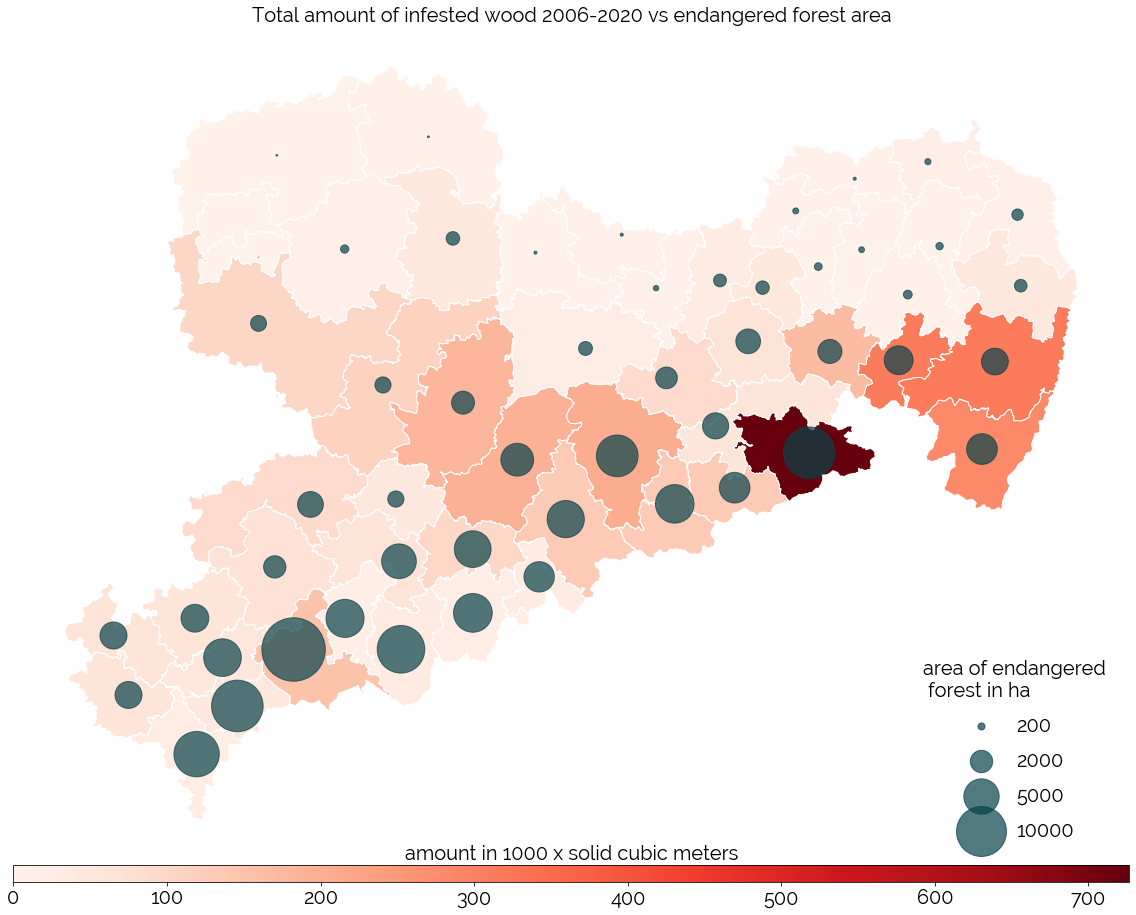

In [5]:
# plot a chloropleth map for the total observations of infested wood in 
# the forestry districts plus a bubble map for the endangered forest area

# read shapefile with geodata (geometry needed for map, not in data set)
# we first 52 rows are needed since these are the current districts
districts_gdf = gpd.read_file(
    r'forestry_districts.shp', 
    encoding='utf-8'
).loc[:52]

# name columns according to first notebook
districts_gdf.columns = [
    'county_name', 'fdist_name', 'fdist_id', 'area_nse', 'area_nsne', 
    'area_se', 'area_sne', 'area_fdist', 'endangered_forest_density', 
    'centroid_xcoord', 'centroid_ycoord', 'geometry'
]

# get the total amount of damaged wood for every forestry district
total_infested_wood = data.groupby('fdist_name')['infested_wood'].sum()

# make this information on total amount of damaged wood a column 
# in the geodataframe 
districts_gdf['total_infested_wood'] = [
    total_infested_wood.loc[
        total_infested_wood.index == district_name
    ].item()/1000 for district_name in districts_gdf['fdist_name']
]

# create column with total amount of endangered forest area 
# (add private and state owned together)
# scale by a factor to get the nice bubble sizes, 
# later scale the same amount in legend
area_scale = .25
districts_gdf['area_endangered'] = (
    districts_gdf['area_nse'] + districts_gdf['area_se']
) * area_scale

# create figure
fig, ax = plt.subplots(figsize=(20,20))

# plot title
plt.title(
    'Total amount of infested wood 2006-2020 vs endangered forest area', 
    fontdict={'fontsize': 20}
)

# custom legend for colormap requires locateable axis
divider = make_axes_locatable(ax)
cax = divider.append_axes(
    # colormap parameters
    "bottom", size="2%", pad=0.1 
) 

# plot the forestry districts chloropleth map
districts_gdf.plot(
    ax=ax, column='total_infested_wood', 
    legend=True, cax=cax, legend_kwds={'orientation': 'horizontal'},
    edgecolor='white', linewidth=1,
    cmap=truncate_colormap(plt.get_cmap('Reds'), 0.02, 1)
)

# colormap legend title and tick fontsize
plt.title(
    'amount in 1000 x solid cubic meters', 
    fontdict={'fontsize': 20}
)
cax.tick_params(labelsize=20)

# add bubble map 
# calculate representative points from polygons (used as bubble location)
gdf_points = districts_gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].representative_point()

# plot bubbles
gdf_points.plot(
    ax=ax, 
    color='#07424A', 
    markersize='area_endangered', 
    alpha=.7, 
    categorical=False, 
    legend=True
)

# make some dummy points at 0,0 
# to use as custom handles in bubble plot legend
ax.scatter([0], [0], c='#07424A', alpha=.7, s=200*area_scale,
            label='200')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=2000*area_scale,
            label='2000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=5000*area_scale,
            label='5000')
ax.scatter([0], [0], c='#07424A', alpha=.7, s=10000*area_scale,
            label='10000')

# add bubble map legend
ax.legend(
    scatterpoints=1, 
    frameon=True,
    labelspacing=.8, 
    loc='lower right', 
    fontsize=20, 
    edgecolor='white',
    bbox_to_anchor=(1,0), 
    title_fontsize=20, 
    title='area of endangered \n forest in ha'
);

# x and y axis settings
ax.set_xlim(267100.4013500002, 514160.39804999967);
ax.set_ylim(5552730.938154999, 5736554.970745001);
ax.axis('off');

To get better understanding of these amounts, show the top and bottom values to complement the plot:

In [6]:
# first restore the original amount of damaged wood and 
# endangered forest area (revert any scaling)
districts_gdf['area_endangered'] = districts_gdf[
    'area_endangered'
] / area_scale

districts_gdf['total_infested_wood'] = districts_gdf[
    'total_infested_wood'
] * 1000

# get top and bottom rows regarding amount of damaged wood
district_info = districts_gdf[[
    'county_name', 'fdist_name', 'total_infested_wood', 'area_endangered'
]].sort_values('total_infested_wood', 
               ascending=False)

district_info.head(4).append(district_info.tail(4))

county_name fdist_name  total_infested_wood  \
38  Sächsische Schweiz-Osterzgebirge    Sebnitz            726589.19   
42                           Görlitz      Löbau            317423.00   
20                           Bautzen  Cunewalde            314677.26   
19                           Görlitz     Zittau            283009.66   
6                        Nordsachsen  Delitzsch               313.14   
14                            Meißen     M West                85.00   
48          Kreisfreie Stadt Leipzig  Connewitz                 0.00   
49          Kreisfreie Stadt Leipzig   Leutzsch                 0.00   

    area_endangered  
38         10611.80  
42          2879.04  
20          3332.18  
19          3772.59  
6             11.40  
14            36.16  
48             0.54  
49             0.00

The first thing that sticking out while looking at the map is the dark red shade of the *Sebnitz* forestry district. The amount of total observed infested wood far exceeds that of the other forestry districts. All in all, some correlation exists between the amount of damaged wood and the area of endangered forest. However there are apparently further factors at play. For example although the area of endangered forest of the forestry districts of the *Görlitz* county in the east and the *Erzgebirgskreis* in the central south are comparable, *Görlitz* has much higher amounts of damaged wood.

## 2.3 The role of endangered forest area

Let's take a closer look at relationship between area of endangered forest and amount of damaged wood. 

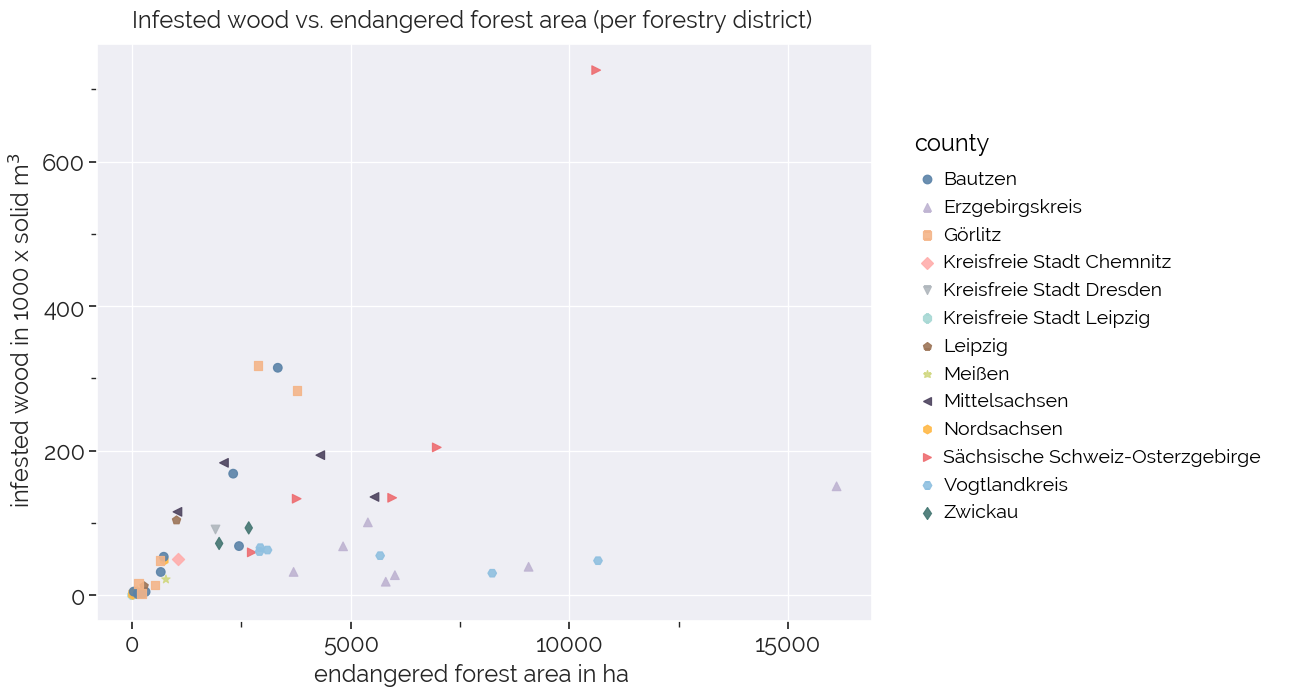

In [7]:
# make a scatterplot: infested wood vs endangered forest are
# (one point per forestry district)

(p9.ggplot(districts_gdf, p9.aes(
    'area_endangered' , 'total_infested_wood/1000', color='county_name')) 
 + p9.geom_point(p9.aes(shape='county_name'), size=3, alpha=.9)
 + p9.scale_color_manual(mycolors[:13][::-1], name='county')
 + p9.scale_shape_manual([
     'o', '^', 's', 'D', 'v', '8', 'p', '*', '<', 'h', '>', 'H', 'd'
 ], name='county')
 + p9.ggtitle(
     'Infested wood vs. endangered forest area (per forestry district)'
 )
 + p9.xlab('endangered forest area in ha') 
 + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mytheme
).draw();

Both plots considered, it seems plausible that moderate correlation exists between the area of endangered forest and the target variable. An additional conclusion from the second plot is that every county seems to have its own distinct coefficient that roughly describes the strength of this relationship. 

## 2.4 Historic development of the bark beetle population

Now that the local context was examined, let's get an overview of the chronological infestation development. For this, the timestamp feature of the data set is useful.

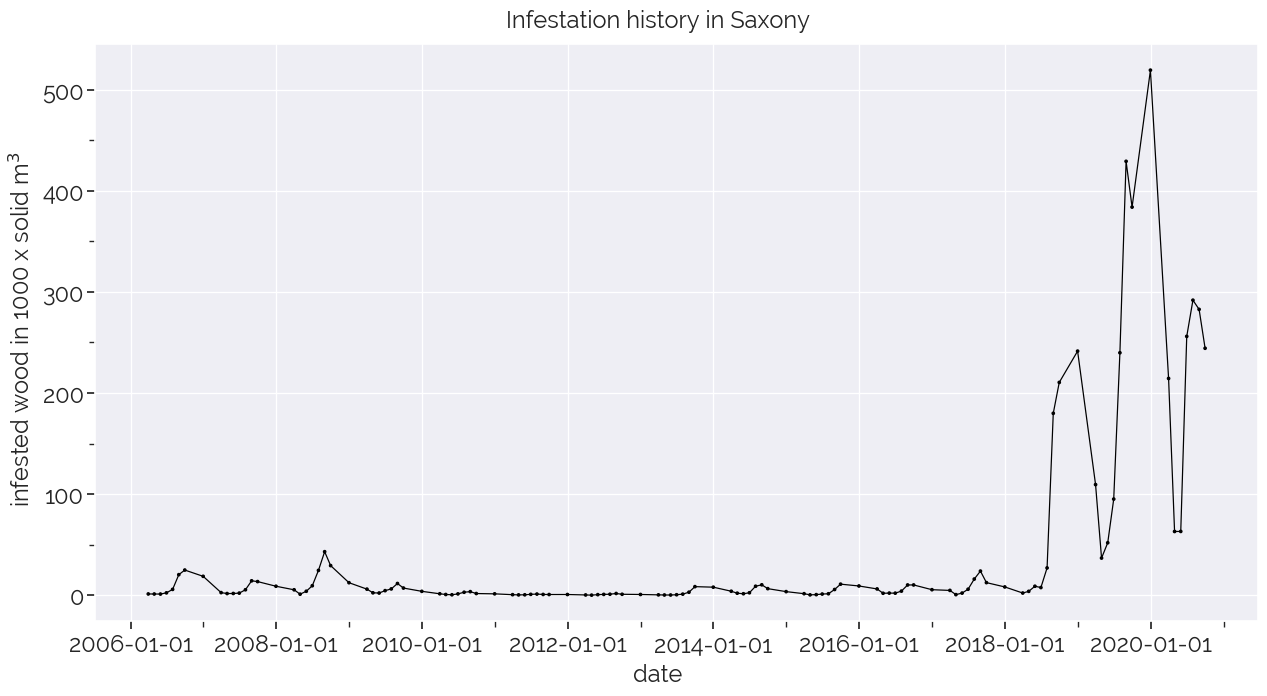

In [8]:
# add together all observations of every timestamp post 2005
inf_sum = data[data['year'] > 2005].groupby('timestamp')['infested_wood'].sum()

# plot inf_sum on timeline
(p9.ggplot(p9.aes(inf_sum.index, inf_sum.values / 1000)) 
 + p9.geom_line()
 + p9.geom_point(size=.5)
 + p9.ggtitle('Infestation history in Saxony')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

The seriousness of the current bark beetle situation is evident in this plot. The infestation (and thus resulting forest dieback) that took place during the last three years is on another scale than everything that came before. Even the at the time worrying infestation from 2008 is dwarfed by the amount of infested wood post 2017. 

Since the seasonal nature of the infestation is difficult to gleam from this graphic, the plot is recreated with a logarithmically scaled y-axis.

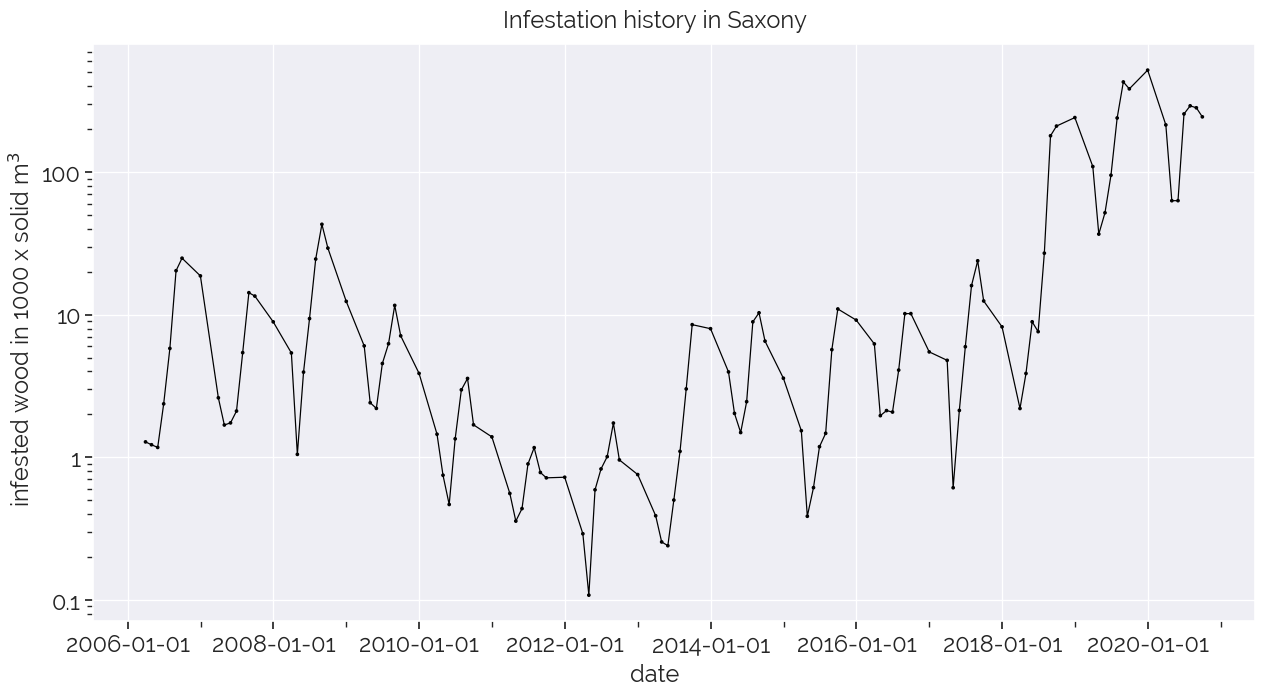

In [9]:
# plot inf_sum on timeline with logarithmic y-axis
(p9.ggplot(p9.aes(inf_sum.index, inf_sum.values / 1000)) 
 + p9.geom_line()
 + p9.geom_point(size=.5)
 + p9.scale_y_log10()
 + p9.ggtitle('Infestation history in Saxony')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

Now the yearly highs are more distinguishable. In the early years they seem to occur in August and September. In the later years, the infested wood peaks during the summarized period of October-December (most likely because they **are** summarized, otherwise one could assume the peak would still be in September due to their small difference). The lowest values exist in April, but again the summarization of three months into one just before April makes it difficult to draw a definite conclusion regarding this fact. The existence of a seasonal component/cycle to the infestation is evident in any case. All in all, the years with the highest amount of infested wood are (in that order) 2019, 2020, 2018 (followed by 2008) and the years with the lowest total amount of infested wood are 2011, 2012 and 2010. This should be kept in mind for the investigation of meteorological parameters.

In addition to the total amount of infested wood, an ancillary plot with the amount of infested wood, aggregated for each of the 13 counties, is created. 

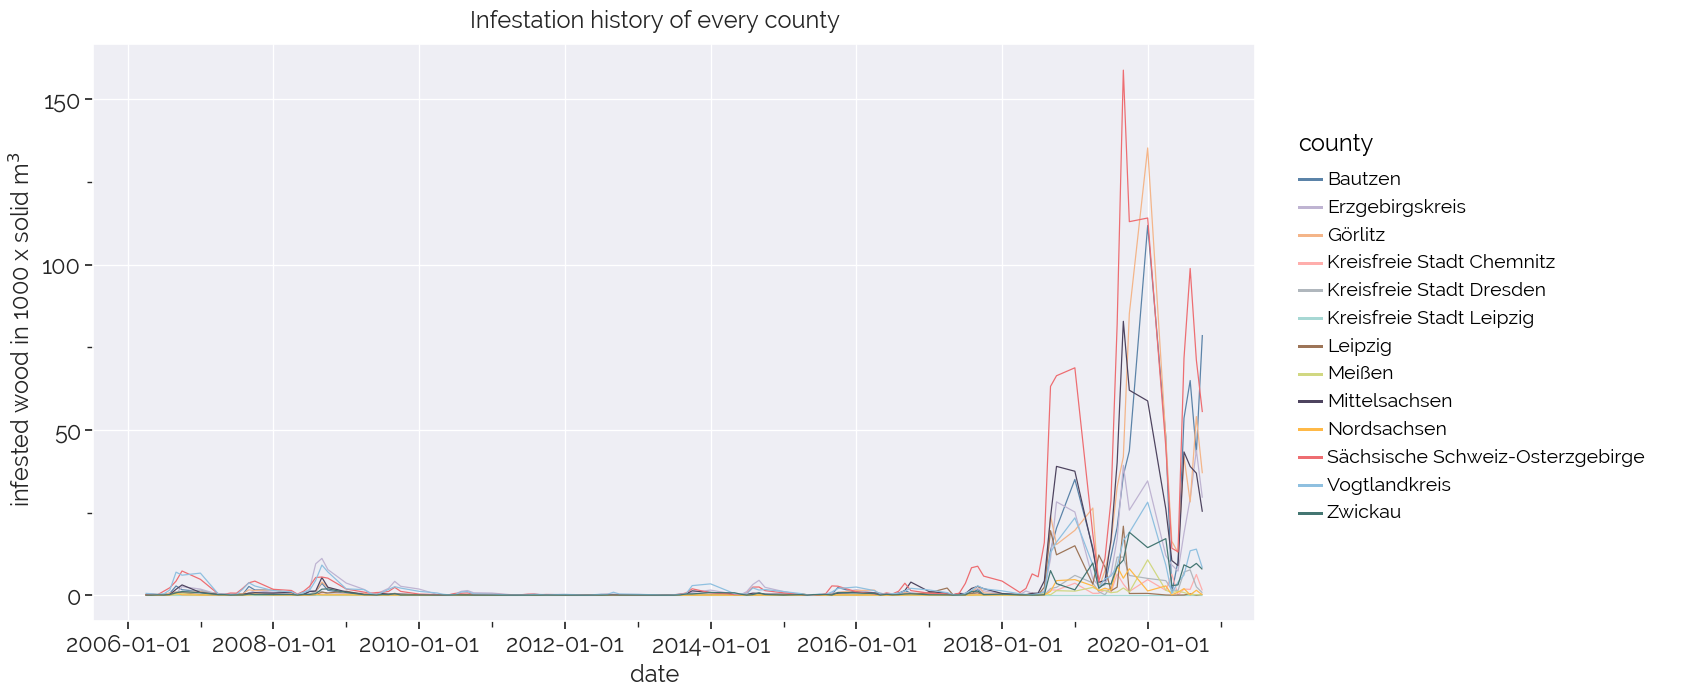

In [10]:
# add together data after 2005, grouped by county and timestamp
inf_sum_c = data[data['year'] > 2005].groupby(['timestamp','county_name'])[
    'infested_wood'
].sum().reset_index()

(p9.ggplot(inf_sum_c, p9.aes('timestamp', 'infested_wood / 1000', color='county_name'))
 + p9.geom_line()
 + p9.scale_color_manual(mycolors[:13][::-1], name='county')
 + p9.ggtitle('Infestation history of every county')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

For visibility and comprehensibility reasons, the same plot is recreated with only the observations pre 2018.

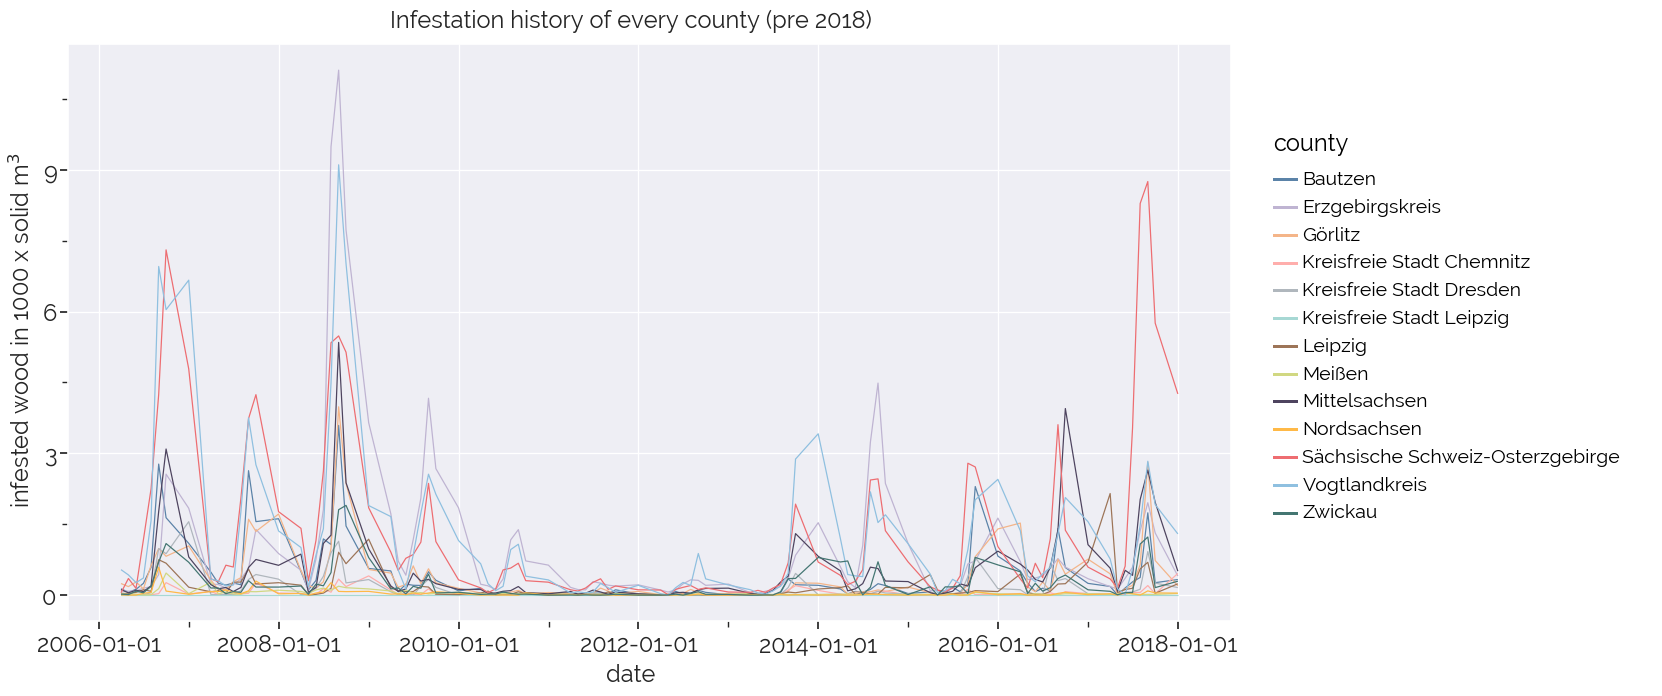

In [11]:
(p9.ggplot(inf_sum_c[
    inf_sum_c['timestamp'] < pd.Timestamp('2018-01-01')
], p9.aes('timestamp', 'infested_wood/1000', color='county_name')) 
 + p9.geom_line()
 + p9.ggtitle('Infestation history of every county (pre 2018)')
 + p9.xlab('date') + p9.ylab('infested wood in 1000 x solid m$^3$')
 + p9.scale_color_manual(mycolors[:13][::-1], name='county')
 + mythemewide
).draw();

The plot reiterates what was learned so far. 2008 was the previously highest year regarding the amount of infested wood, while the years 2010 - 2012 were the lowest years in that respect. The chronological plots correspond with the map and scatterplot, in that the county *Sächsische Schweiz-Osterzgebirge*, where the forestry district *Sebnitz* lies, consistently is among the top counties with regards to the amount of infested wood. On the other hand, the county *Erzgebirgskreis* has the greatest peaks of any county in 2008, 2009 and 2014, but is affected less in the years from 2018 onwards and thus lies behind in total amount of infested wood (see scatterplot). This is interesting, because it does have among the greatest area of endangered forest. This is something our final model will have to deal with and account for. We will keep this in mind for the analysis of meteorological parameters. 

(As a reminder, a map of Saxony with all counties and forestry districts can be found above and in the project repository.)

# 3 Target variable distribution

The way we padded the data set with rows containing zero infested wood during data aggregation is reason to assume a skewed target variable distribution in the data set. Let's see how some stats on the distribution within the dataframe rows.

In [12]:
# number of rows with zero infested wood
zero_rows = data[data['infested_wood'] == 0].shape[0]

# number of rows with infested wood greater than zero and lower than 100
zero_to_hundred = data[
    (data['infested_wood']>0) & (data['infested_wood']<=100)
].shape[0]

# ten highest observations of infested wood
top_ten = data.sort_values(
    'infested_wood', ascending=False
)['infested_wood'].values[:10]                  

# print results
print(f'There are {data.shape[0]} rows in the data set.\n')                 
print(f'Of these rows, {zero_rows} contain an infested wood amount of zero.')
print(f'Additionally, there are {zero_to_hundred} rows with an amount',
      f'of infested wood between zero and 100 solid cubic meters.')
print(f'On the other hand, the top values of infested wood are {top_ten}')

There are 13484 rows in the data set.

Of these rows, 6640 contain an infested wood amount of zero.
Additionally, there are 4552 rows with an amount of infested wood between zero and 100 solid cubic meters.
On the other hand, the top values of infested wood are [114300.  90065.  78364.  60813.  60000.  54900.  51800.  46304.  44333.
  43130.]


These results indicate a skewed distribution. We plot the distribution in a density plot. Due to the results that were just printed, the x-axis will be scaled logarithmically (log1p-transformation).

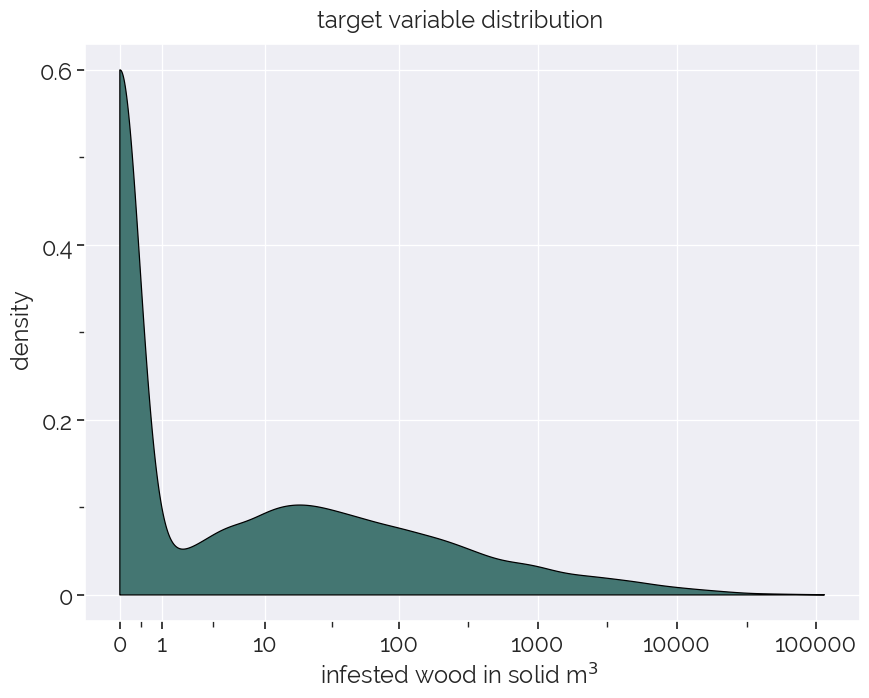

In [13]:
# density plot of target variable distribution
(p9.ggplot(data, p9.aes(x='infested_wood')) 
 + p9.geom_density(fill=mycolors[0])
 + p9.scale_x_continuous(trans="log1p", 
                         breaks=[0, 1, 10, 100, 1000, 10000, 100000])
 + p9.ggtitle('target variable distribution')
 + p9.xlab('infested wood in solid m$^3$') 
 + p9.ylab('density')
 + mytheme
).draw();

As expected, there is a left-skewed target variable distribution. Most values lie between zero and one. Interestingly, the plot contains two maxima, almost as if there are two underlying distributions. A different view of the same distribution is provided by a histogram, but this time with the y-axis logarithmically scaled, as the 'Infestation history in Saxony' gave a good understanding of the data with this transformation. The bin width of the histogram is 2000 solid m$^3$.

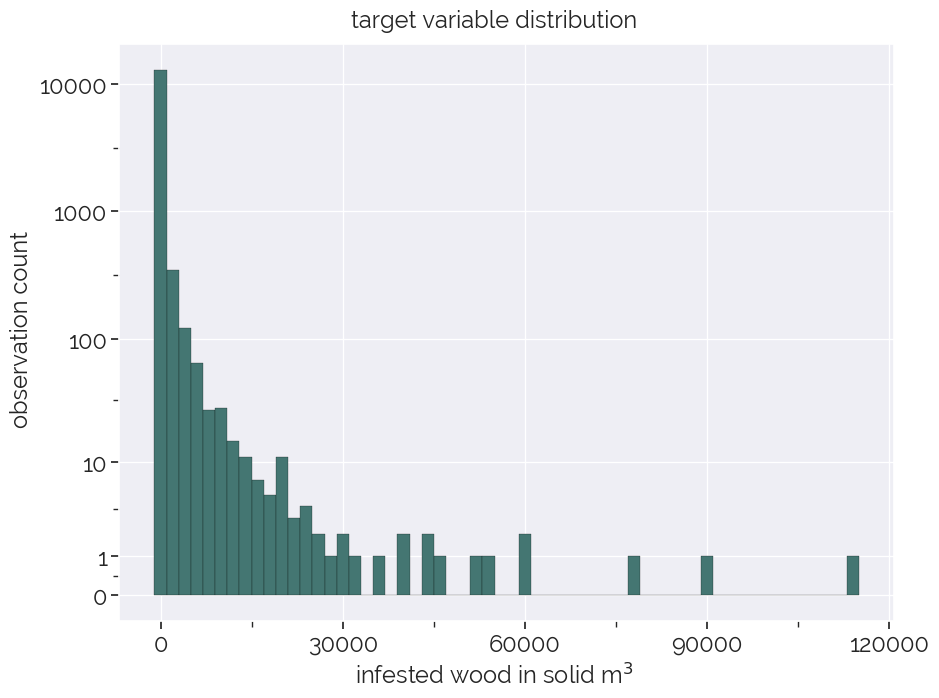

In [14]:
# histogram of target variable distribution
(p9.ggplot(data, p9.aes(x='infested_wood')) 
 + p9.geom_histogram(binwidth=2000, fill=mycolors[0], color='black', size=.1)
 + p9.scale_y_continuous(trans="log1p", breaks=[0, 1, 10, 100, 1000, 10000])
 + p9.ggtitle('target variable distribution')
 + p9.xlab('infested wood in solid m$^3$') 
 + p9.ylab('observation count')
 + mytheme
).draw();

As the x-axis is no longer logarithmically scaled, the first bin with a width of 2000 solid m$^3$ swallows the two different distributions of the last plot, so that they are no longer visible. On the other hand, in the second plot the top ten single values of infested wood are distinctly visible, which was not the case in the density plot. 

The combination of these two plots highlights a peculiarity in the data set. If a regression model is to reduce its prediction error (optimize the loss function), then imbalance in the data may cause the prediction either favour the many small values (always predict lower values for the later years) or the few extremely large values (either predicting too much infested wood for the many districts with almost no infested wood and the years pre 2018 OR just 'ignoring' them and adopt a value of zero). This suggests that the model loss should be carefully chosen. All in all, the plots promote a deeper understanding of the target variable observations.

# 4 Meteorological features
## 4.1 Correlation matrix

There are 15 different meteorological parameters in the data set. Based on names alone, some of them seem to be very similar, i.e. the total precipitation (RRU) and the corrected precipitation (RRK) or the wind velocity 10 meters above ground (FF1) and the wind speed on the beaufort scale (FFB). Even if that were not the case, a correlation matrix can spot problematic relationships between features and enable us to choose meaningful predictors. So as a first examination of the climate based features, a correlation matrix is plotted. To make the correlations obvious at a glance, a diverging color palette as well as a point size dependant on the absolute correlation coefficient is chosen.

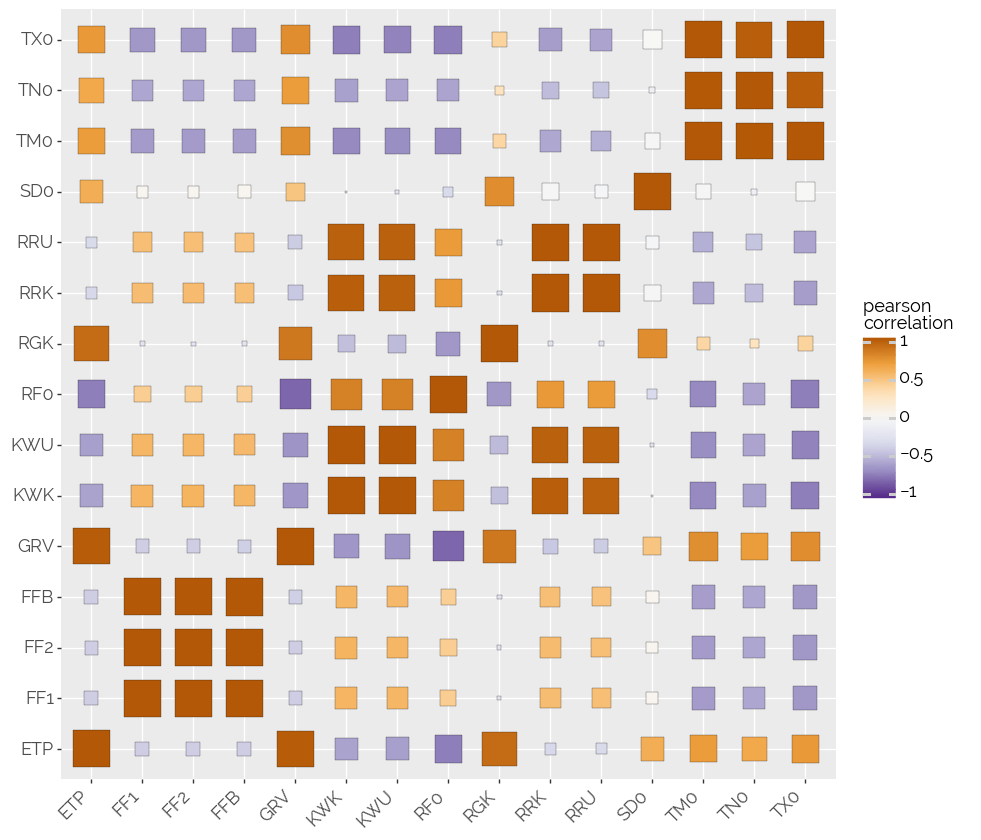

In [15]:
# define function for correlation heatmap (correlation matrix)
def heatmap(x, y, size, color, pear=True):
    '''
    This function will plot a correlation heatmapof the input variables.
    inputs:
        - x, y: two array-likes with all combinations of feature labels
        - size: array-like with the absolute of the 
          pearson correlation coefficient 
        - color: array-like with the pearson correlation coefficient 
    Together x, y, size and color represent data in long format.
    '''
    cor = 'pearson' if pear==True else 'spearman'
    # set figure size
    p9.options.figure_size = (10,10)
    
    # make plot
    (p9.ggplot(p9.aes(x,y, size=size, fill=color, group=1))
    + p9.geom_point(shape='s', stroke=.1)
    + p9.scale_fill_distiller(
        type='div',
        name=f'{cor} \ncorrelation\n', 
        limits=[-1,1],
        palette=4)
     + p9.scale_size_continuous(range=[-10,15], limits=[0,1], guide=False)
     + p9.xlab('') + p9.ylab('')
     + p9.theme(text=p9.element_text(size=13, family='sans-serif'),
                axis_text_x=p9.element_text(rotation=45, hjust=1))
    ).draw();

    
# choose features for this plot
columns =  ['TX0', 'TM0', 'TN0', 'RF0', 'SD0', 'RRU', 'RRK', 'FF1', 
            'FF2', 'FFB', 'RGK', 'ETP', 'GRV', 'KWU', 'KWK']

# calculate pearson correlation
corr = data[columns].corr()

# Unpivot the dataframe, so we can get pair of arrays for x and y 
# (long format)
corr = pd.melt(corr.reset_index(), id_vars='index') 
corr.columns = ['x', 'y', 'value']

# plot heatmap
heatmap( 
    x=corr['x'], 
    y=corr['y'], 
    size=corr['value'].abs(), 
    color = corr['value']
)

The most striking, unambiguous positive correlations exist between:
* The minimum temperature (TN0), mean temperature (TM0) and maximum temperature (TX0). Although they technically are different metrics, the strength of the correlation implies that during model training, we can use them interchangeably, since after scaling they might as well be the same metric. In the following proceedings, only the mean temperature will be explored further.
* The wind velocity 10 meters above ground (FF1), the mean wind velocity 2 meters above ground (FF2) and the wind speed on the beaufort scale (FFB). All of these are measuring wind intensity. The strong correlation is still somewhat unexpected, as the beaufort scale does not rely on exact measurements but instead on observed conditions and thus is not an exact or an objective scale. Nevertheless, in future, only the wind velocity 10 meters above ground will be taken into account. 
* The total precipitation (RRU) and corrected total precipitation (RRK). The method of correcting systematic errors of the measuring device and installation location such as wetting/evaporation losses does not seem to change the interrelation of the measurement values. In the following proceedings, only the corrected precipitation will be explored further.
* The water balance (KWU) and the corrected water balance (KWK). Same as above (precipitation is a parameter of water balance calculation). In the following proceedings, only the corrected water balance will be taken into account.
* The potential evaporation (ETP) and the potential evapotranspiration (GRV). This is expected as evaporation is one part of the evapotranspiration. In the following proceedings, only the evapotranspiration will be explored further.

Based on the strong correlation of particular features, the following eight parameters will be explored further: TM0, RF0, SD0, RRK, FF1, RGK, GRV, KWK.
  

Moderate positive correlation exists between:
* Temperature (TM0) and evaporation (GRV). This corresponds to common knowlegde. Interestingly, the relationship between temperature (TM0) and evapotranspiration (ETP) is slightly smaller.
* Sunshine duration (SD0) and global irradiation (RGK). This behavior is to be expected, as a cloudy or rainy day will have a lower global irradiation than a sunny day.
* Corrected total precipitation (RRK) and relative humidity (RF0). Since precipitation is the main reason for higher humidities, this is also in line with general knowledge.

Moderate negative correlation exists between:
* Temperature (TM0) and wind velocity (FF1). Since strong winds often indicate a change in weather and appear as a precursor to thunderstorms and low pressure areas, which in turn bring with them a lower temperature, this in in line with our life experiences. 
* Temperature (TM0) and corrected water balance (KWK). Since high temperatures indicate direct sunshine and contribute to water evaporation, this correlation is also expected. In months with higher temperatures, a lower water balance seems likely.
* Temperature(TM0) and relative humidity (RF0). As with the above explanations, since rain and sunshine oppose each other, humidity and temperature also do to some degree. Of course the relationships are slightly different in summer and in winter, but the overall tendency remains.
* Global irradiation (RGK) and relative humidity (RF0). With a laymans understanding of the antagonistic relationship between sunny weather and heavy rain, and their effect on humidity, this relationsip can also be sufficiently explained.

Slighter positive and negative correlations still remain to be explored, however they all can be explained in accordance with the above statements. Even though the strongest, most impairing correlations were already eliminated, a further reduction of features might be necessary before model training. 

## 4.2 Grasping the feature-target relationships

Let's take a look at the relationship between these parameters and the target variable. Since the goal is to only portray the influences of the meteorological parameters and not the influences that come with the respective forestry districts (forest area etc.), normalizing the target variable values for either counties or forestry districts is paramount. Otherwise these values will not show any discernable relationships in these plots. For example the values of *Sächsische Schweiz-Osterzgebirge* will always be monumentally higher than those of *Meißen*, no matter the actual temperature of these observations. In this first attempt to plot the relationships, we group by forestry districts.

As we already saw multiple times, logarithmic scaling is required to get the many low and few extraordinarily high target variable values (the differences in magnitude still exist after normalizing) in a mutual plot.

In [16]:
# for clarity regarding the variable names, create labeller functions
def mylabeller_units(var):
    label_dict = {
        'FFB': 'wind speed in bft',
        'GRV': 'pot. evapotranspiration in mm',
        'KWK': 'corrected water balance in mm',
        'RF0': 'relative humidity in %',
        'RGK': r'solar irradiation in kWhm$^-$$^2$',
        'RRK': 'corrected precipitation in mm',
        'SD0': 'sunshine duration in h',
        'TM0': 'mean temperature in $°$C',
    }
    return label_dict.get(var)

def mylabeller_names(var):
    label_dict = {
        'FFB': 'wind speed',
        'GRV': 'pot. evapotranspiration',
        'KWK': 'corrected water balance',
        'RF0': 'relative humidity',
        'RGK': 'solar irradiation',
        'RRK': 'corrected precipitation',
        'SD0': 'sunshine duration',
        'TM0': 'mean temperature',
    }    
    
    return label_dict.get(var)

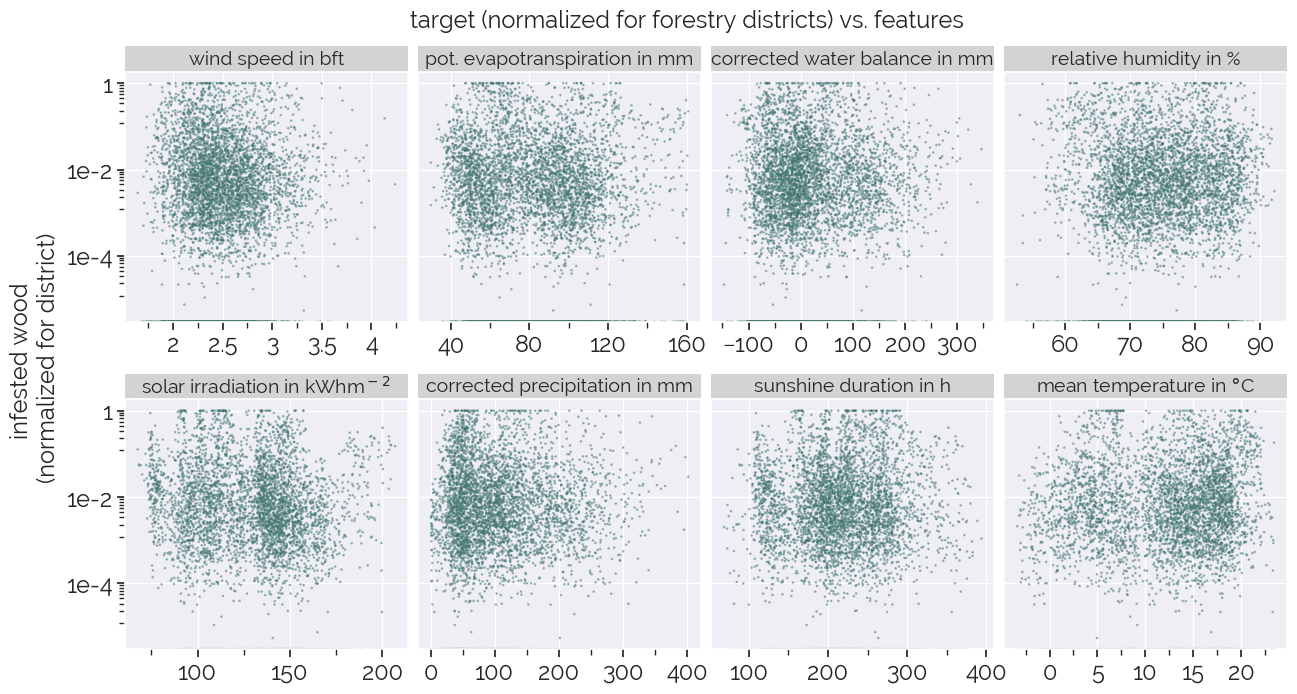

In [17]:
# initial graphic - grouped for forestry districts

# use a copied dataframe so transformations aren't applied to main data set
# only take into account years with target variable observations
draw = data[(data['year'].isin(range(2006,2020)))].copy()

# group target variable by forestry district and timestamp, 
# aggregate data by summation
draw['infested_wood'] = draw.groupby(
    ['fdist_newname', 'timestamp']
)['infested_wood'].transform('sum')

# group features by forestry district and timestamp, calculate mean
for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['fdist_newname', 'timestamp'])[v].transform('mean')
draw.drop_duplicates(['fdist_newname', 'timestamp'], inplace=True)

# normalize target variable with minmax scaler
draw['infested_wood'] = draw.groupby('fdist_newname')[
    'infested_wood'
].transform(lambda x: minmax_scale(x))

# transform from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, 
    id_vars=['infested_wood'], 
    value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']
)

# create plot
(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(size=.1, alpha=.4, color=mycolors[0])
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller_units)
 + p9.scale_y_log10()
 + p9.ggtitle('target (normalized for forestry districts) vs. features')
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)')
 + mythemewide
).draw();

Despite the normalization as well as the scaling, meaningful relationships are not apparent in this plot. 

In a second attempt, the plot is recreated with reduced clutter by grouping by county instead of forestry district. As a consequence, the number of individual points is diminished. There is a slight problem with this approach however: The mean of climate parameters of every district in a county does not evaluate to the mean of the climate parameter when calculated for the county itself. This is because the forestry districts vary by area. To get the correct value for the mean of a parameter in the respective county, the aggregation of raster data would need to be done again for every county border. Instead, a workaround is used. When calculating the county mean, we take into account the respective forestry district area as a weight, then divide by the total county area. This way, the correct values area approximated. In addition the normalization with a minmax scaler is also done for the features (relative to all parameter values in the county). 

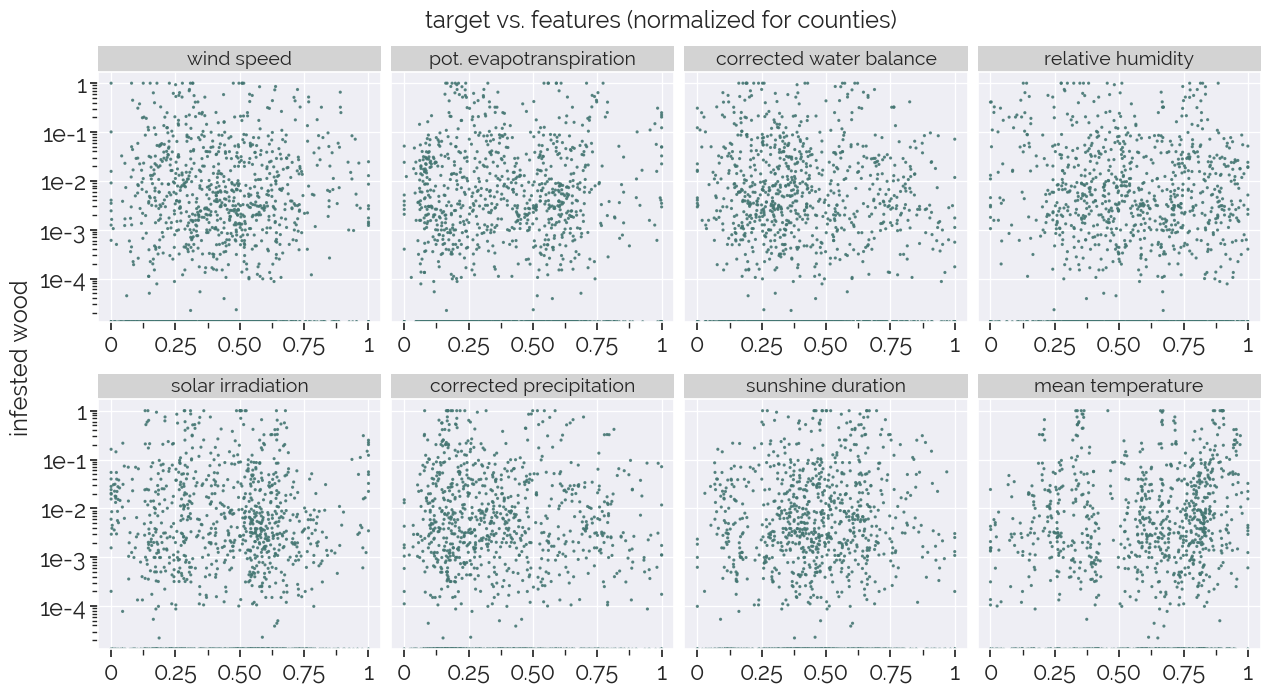

In [18]:
# second graphic - grouped for counties

# use a copied dataframe so transformations aren't applied to main data set
# only take into account years with target variable observations
draw = data[(data['year'].isin(range(2006,2020)))].copy()

# group target variable by county and timestamp, aggregate data by summation
draw['infested_wood'] = draw.groupby(
    ['fdist_newname', 'timestamp']
)['infested_wood'].transform('sum')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    # multiply all values by forestry district area (weight)
    draw[v] = draw[v] * draw['area_fdist']
    
    # sum up weighted target variable 
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('sum')
    
    # sum up all forestry district areas in respective counties
    draw['area_county'] = draw.groupby(['county_name', 'timestamp'])[
        'area_fdist'
    ].transform('sum')
    
    # technically area_county has the area multiplied by 2
    # since there are two observations per forestry district
    # (non-state- and state-owned forest)
    #
    # the same is true for the target variable however so for the 
    # fraction this does not matter
    draw[v] = draw[[v, 'area_county']].apply(lambda x: x[0]/x[1], axis=1)
    
    # scale minmax for county
    draw[v] = draw.groupby('county_name')[v].transform(
        lambda x: minmax_scale(x)
    )

# drop duplicates
draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)

# normalize target variable with minmax scaler
draw['infested_wood'] = draw.groupby('county_name')[
    'infested_wood'
].transform(lambda x: minmax_scale(x))

# transform from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, 
    id_vars=['infested_wood'], 
    value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK'])

# plot
(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(size=.3, alpha=.8, color=mycolors[0])
 + p9.facet_wrap('variable', scales='free_x', ncol=4, labeller=mylabeller_names)
 + p9.scale_y_log10()
 + p9.ggtitle('target vs. features (normalized for counties)')
 + p9.xlab('') + p9.ylab('infested wood')
 + mythemewide
).draw();

I this second plot, meaningful relations are still not apparent. The aggregation of counties does improve visibility though. Before we continue improving on the concept of these plots, let's take a step back. 

Based on the beetle biology, one can assume that some meteorological parameters have different influences in winter than in summer. Below temperatures of 8 °C, the beetles lapse into torpor and thus are unable to reproduce or infest new trees. Taking this into consideration, some features such as precipitation might have less influence on the target variable in winter than in summer. Maybe some features affect the beetle antagonists or the spruce tree defense system during winter in different ways than they affect the beetles themselves. This in turn would introduce new effects, that might be superimposing each other. All in all, the separation into winter and summer months is a lead worth investigating.

In the following section, we track the chronological development of the meteorological parameters, separated into winter and summer semesters. One 'winter' in this context is the last three months of a given year and the next three months of the subsequent year (so for example the winter 2008/2009, not the six winter months of 2008, which would be chronologically separated by the summer between them). Keep in mind, the three years with the highest target variable are 2018, 2019 and 2008, while the years with the lowest target variable are 2010, 2011 and 2012. 

We first create a function that is able to plot one individual chronological boxplot and then call it for the respective meteorological features.

In [19]:
# function that makes a chronological boxplot of a parameter, 
# separated into winter and summer months
def climate_boxplot(param, aggfunc, data=data):
    '''
    This function separates one feature of a given dataframe into subsequent 
    summers and winters, aggregates them in a specified way and creates a 
    chronological boxplot with them.
    
    inputs:
        - param: the name of the feature as a string
        - aggfunct: the aggreagation funciton as a string
        . data: the data set
    '''
    # select only data from winter 2005/2006 untill winter 2019/2020
    draw = data[data['timestamp'].isin(
        pd.date_range(start='2005-10-01', end='2019-10-01', freq='M')
    )].copy()
    
    # make a dummy feature that distinguishes winter and summer
    # winter = months 10,11,12,01,02,03; summer = months 4,5,6,7,8,9
    draw['season'] = draw['timestamp'].map(
        lambda x: 'winter' if x.month not in range(4,10) else 'summer'
    )
    
    # logically group winters together in 'winteryear' column 
    #
    # winter at end of preceeding year should be grouped with 
    # winter at beginning of subsequent year
    # for example winter 2007/2008 should go 'in between' 
    # summer 2007 and summer 2008
    #
    # take both observations and map them to the preceeding year
    draw['winteryear'] = draw[['year', 'timestamp']].apply(
        lambda x: x[0] if x[1].month != 3 else x[0]-1, axis=1
    )
    
    # every data point is aggregated for the year and forestry district
    draw[param] = draw.groupby(
        ['fdist_newname', 'season', 'winteryear']
    )[param].transform(aggfunc).copy()
    
    # drop duplicates
    draw.drop_duplicates(
        ['winteryear', 'season', 'fdist_newname'], inplace=True
    )
    
    #plot
    (p9.ggplot(p9.aes('factor(winteryear)', 
                      param, fill='factor(season)'), 
               data=draw)
     + p9.geom_boxplot(data=draw[draw['season']=='summer'], width=.35)
     + p9.geom_boxplot(data=draw[draw['season']=='winter'], width=.35,
                       # arrange winters exactly between summers
                       position=p9.position_nudge(x=0.5)) 
     + p9.scale_x_discrete(expand=(0, 0, 0, 1))
     + p9.scale_fill_manual(mycolors[1:3], name='season')
     + p9.xlab('year') + p9.ylab(mylabeller_units(param))
     + mythemewide
    ).draw();

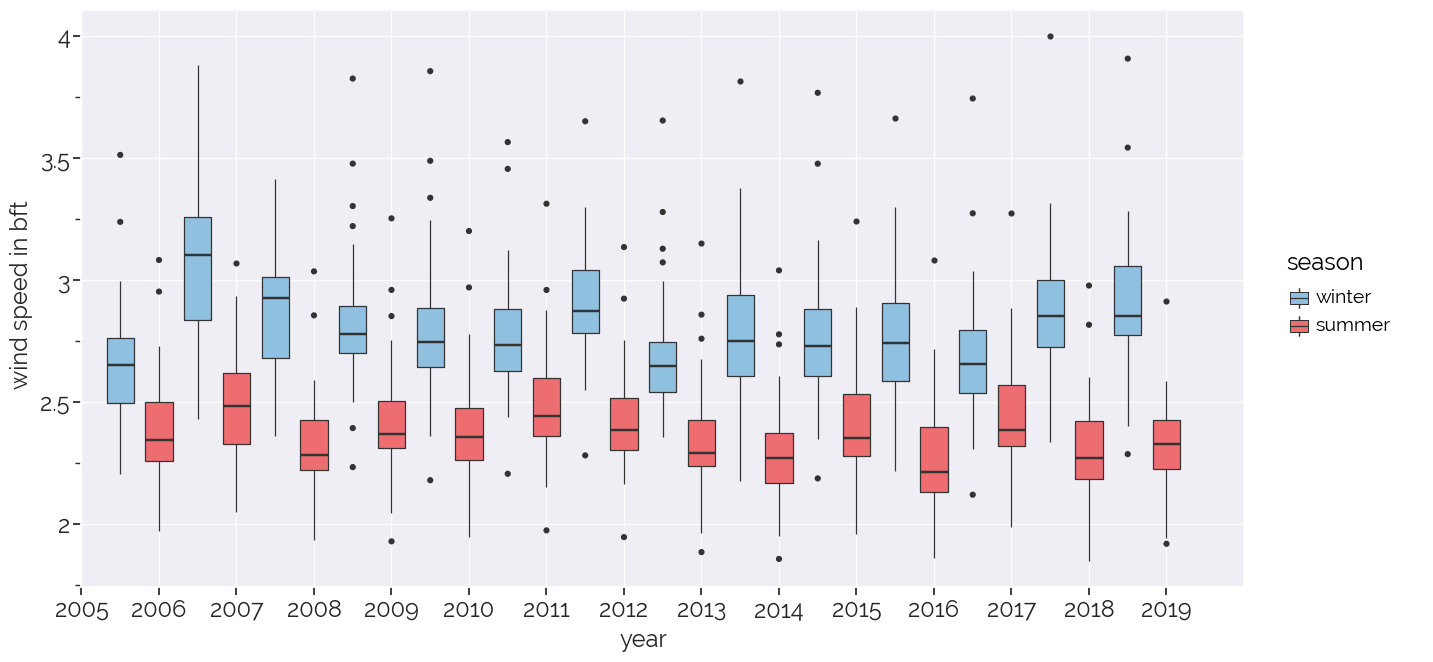

In [20]:
# wind speed in bft
climate_boxplot('FFB', 'mean') 

In the case of wind speed the separation of seasons does not yield reamrkable results. Windspeed may be correlated with thunderstorms and 'bad weather' in general, but on a semi-annual basis this effect gets drownded in noise. The outlier years are not prominently represented in this plot. One thing that maybe influnced by wind speed on this timescale is windfall/demolition wood, which in turn could be an influnce of the target variabel. But even then, the windspeed itself is likely not needed as a feature during model training.  

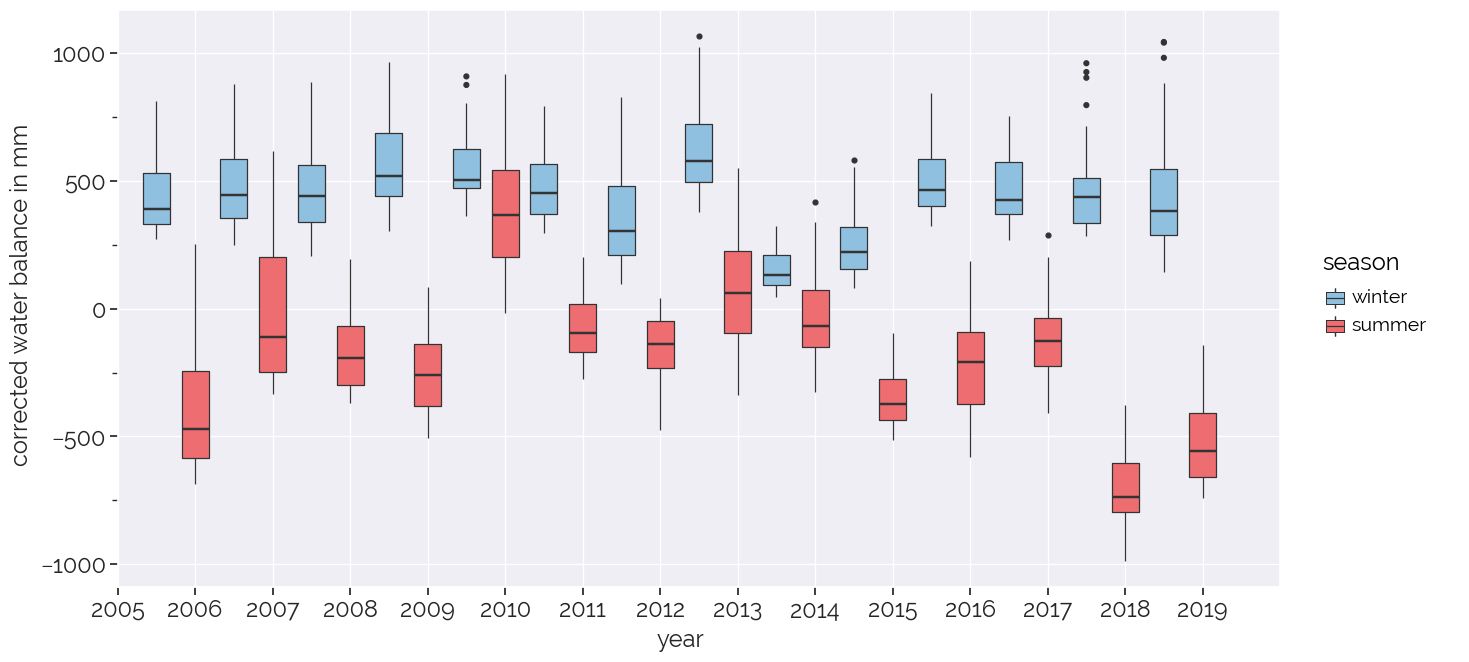

In [21]:
# corrected water balance (precipitation - evapotranspiration)
climate_boxplot('KWK', 'sum') 

For the corrected water balance, a difference between summer and winter months is clearly apparent. For the summer boxes, the critical years of 2018 and 2019 distinctly stand out as the driest on record, while the first summer of the years with the meekest infestation (2010) had the visibly highest corrected water balance. During winter, these years do not stand out at all and there is no correlation with the amount of infested wood of the years. Therefore, it may be practical to exclude winter months in the climate parameter analysis.

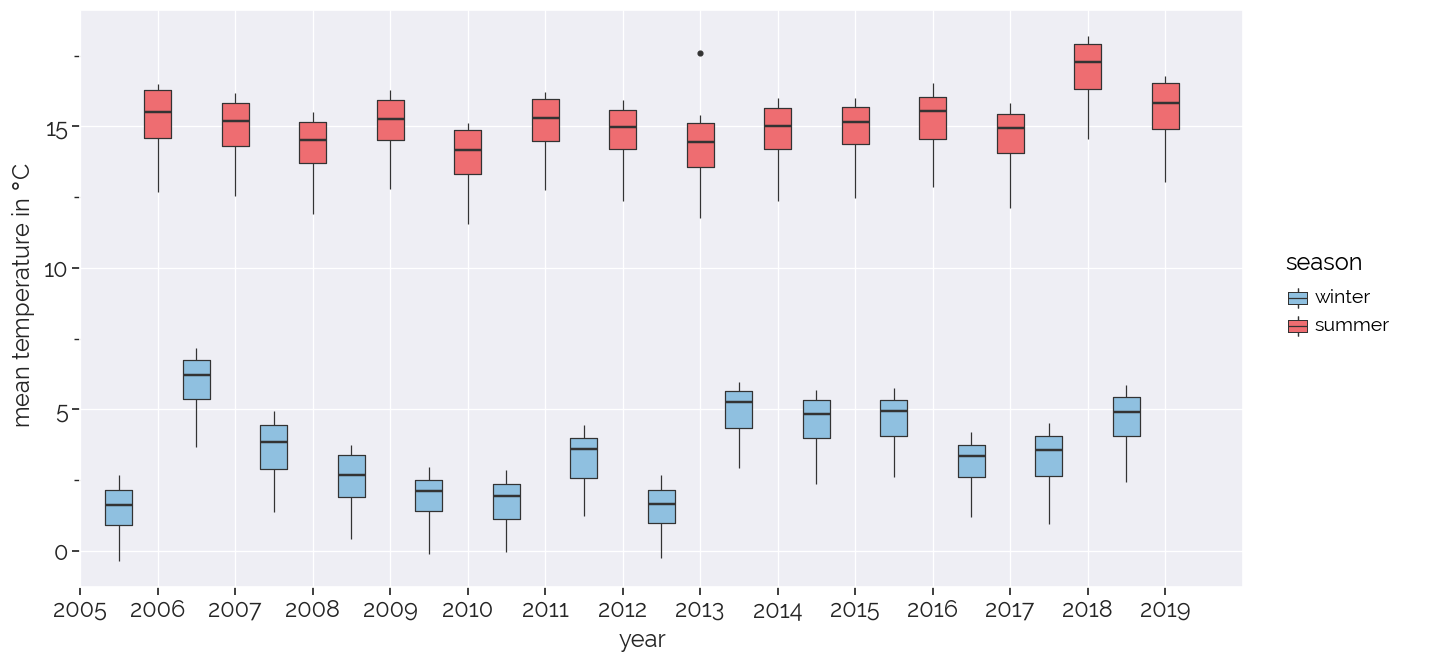

In [22]:
# mean temperature
climate_boxplot('TM0', 'mean') 

For the temperature plot, the summers of 2018 and 2019 are also distinct as the hottest on record, while 2010 was the coldest. Winter, again, has a different order of precedence, although this time it is not too dissimilar.

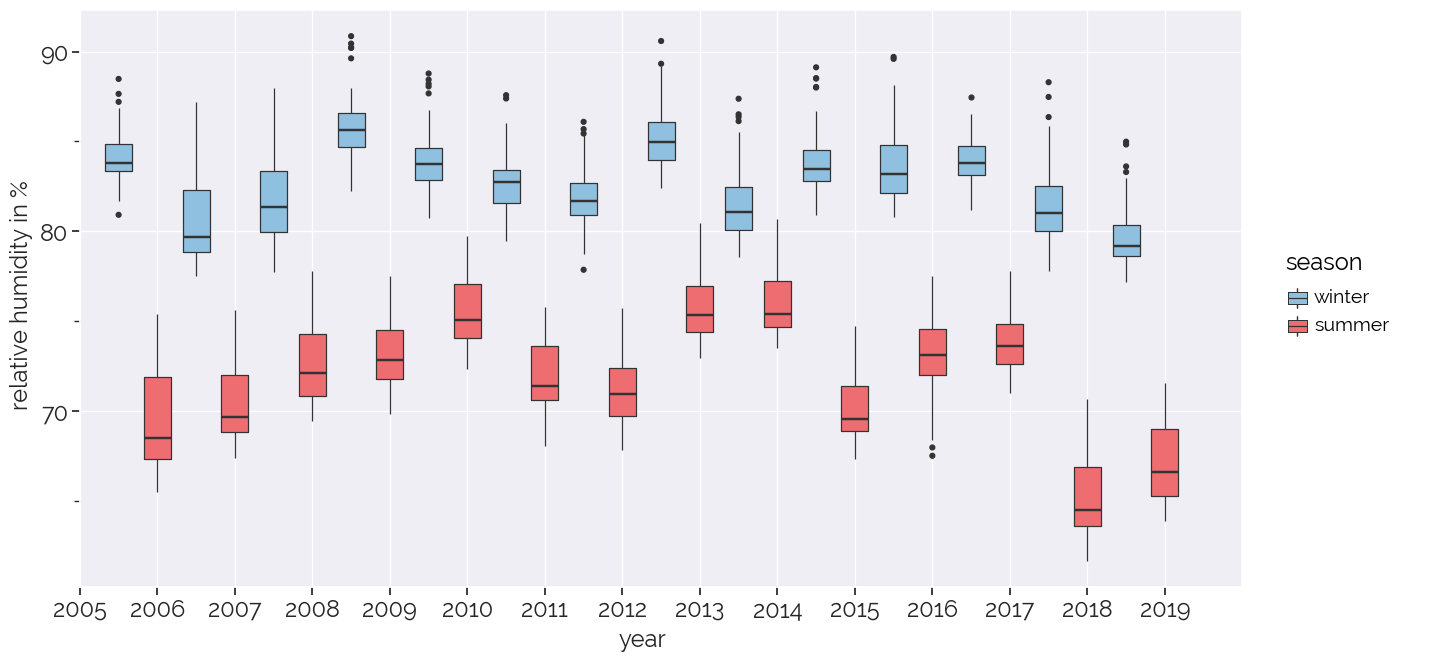

In [23]:
# relative humidity
climate_boxplot('RF0', 'mean') 

Since the correlation between humidity and corrected water balance was already established, it is not surprising that this plot reinforces what was the previous insights, as relative humidity is a factor in determining water balance.

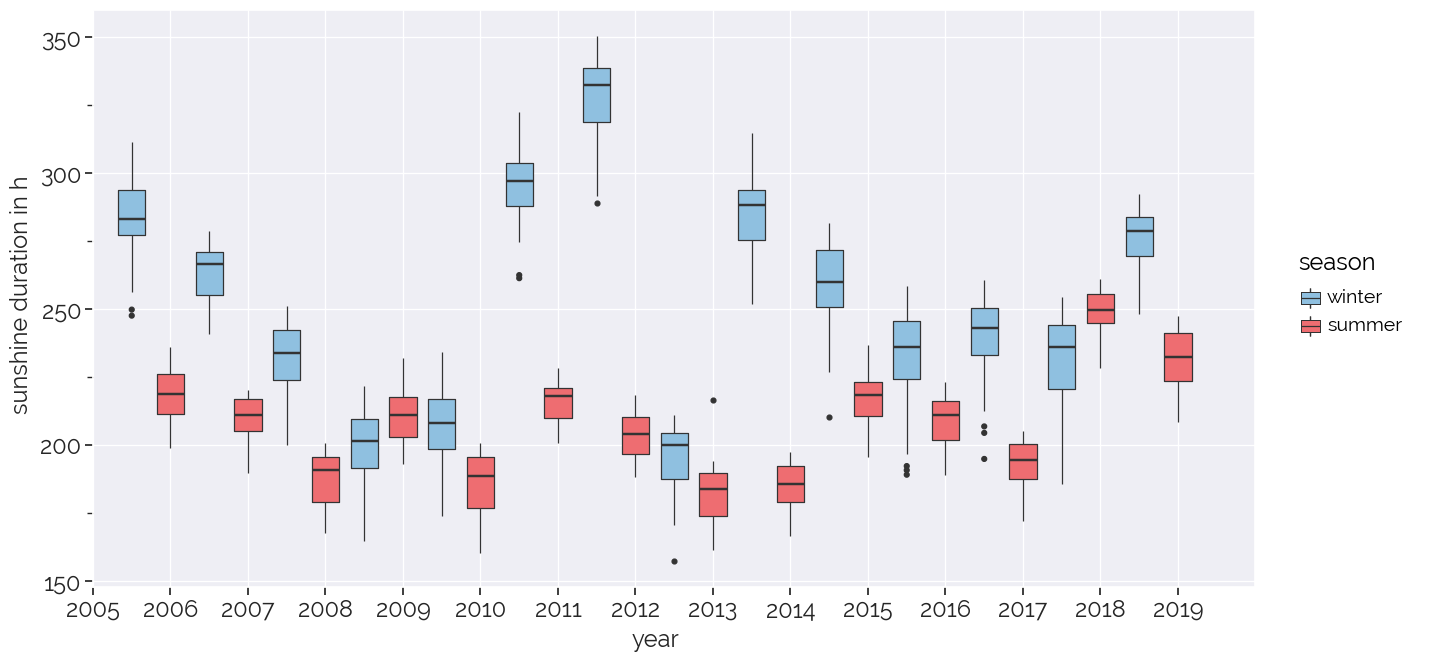

In [24]:
# total sunshine duration
climate_boxplot('SD0', 'mean') 

For the sunshine duration, the sheer value difference between the years (especially winters) is remarkable (if not questionable). Aside from that, the winters of years 2011 and 2012, which had among the lowest infestation area featured prominently. For the summers, again, 2018 and 2019 are prominently featured as outliers, while 2010 had a rather low sunshine duration (but not the lowest).

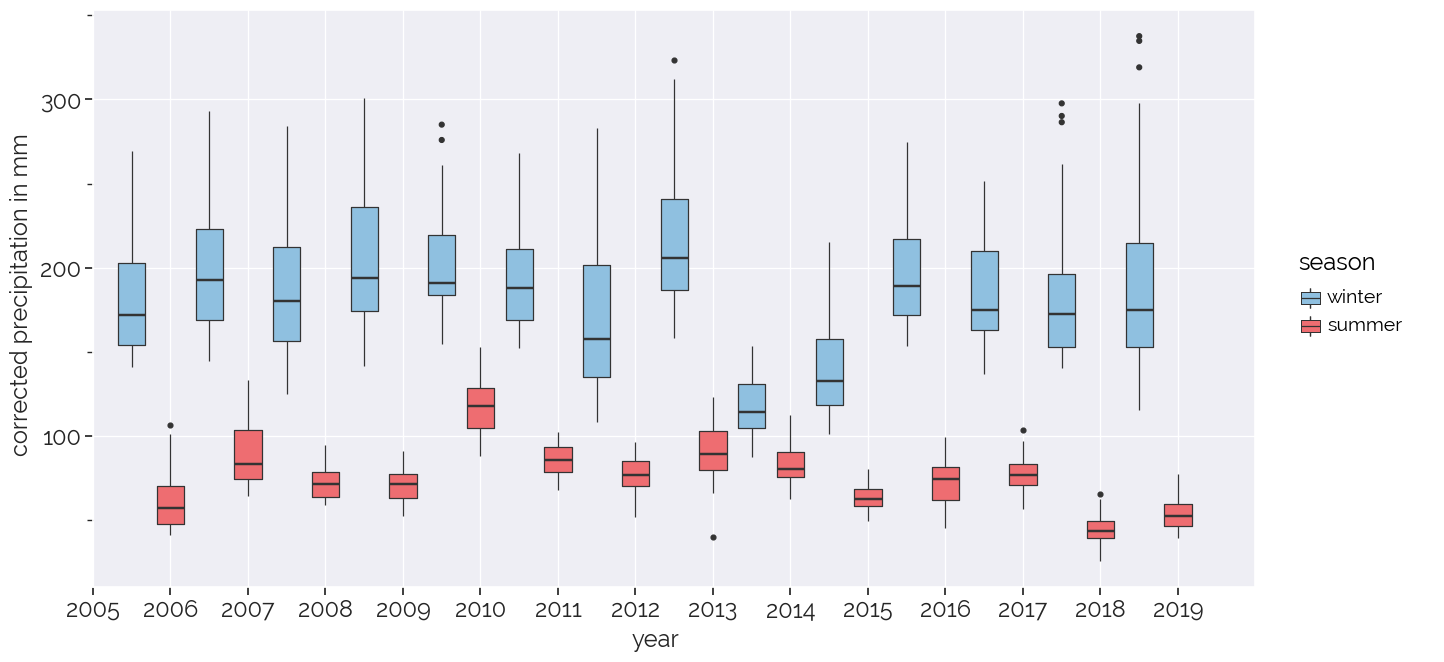

In [25]:
# precipitation
climate_boxplot('RRK', 'mean') 

Since the water balance, of which precipitation is a meaningful component, was already examined, it is not surprising that this plot reinforces the established insights.

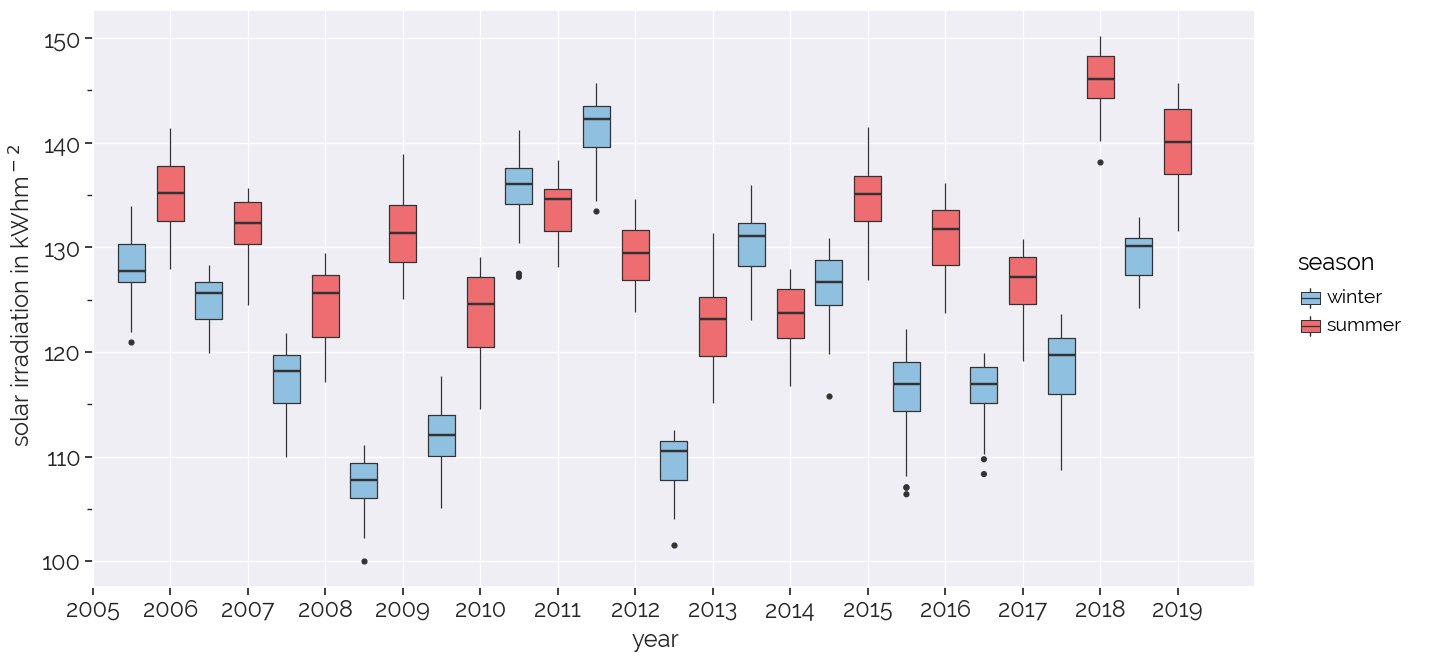

In [26]:
# global solar irradiation
climate_boxplot('RGK', 'mean') 

Qualitatively, this plot mirrors that of the sunshine duration, which is sensible considering the close relation of these parameters. The only major difference is that the absolute values of the summers are higher, because there is generally more irradiation per hour of sunshine in summer than there is in winter. 

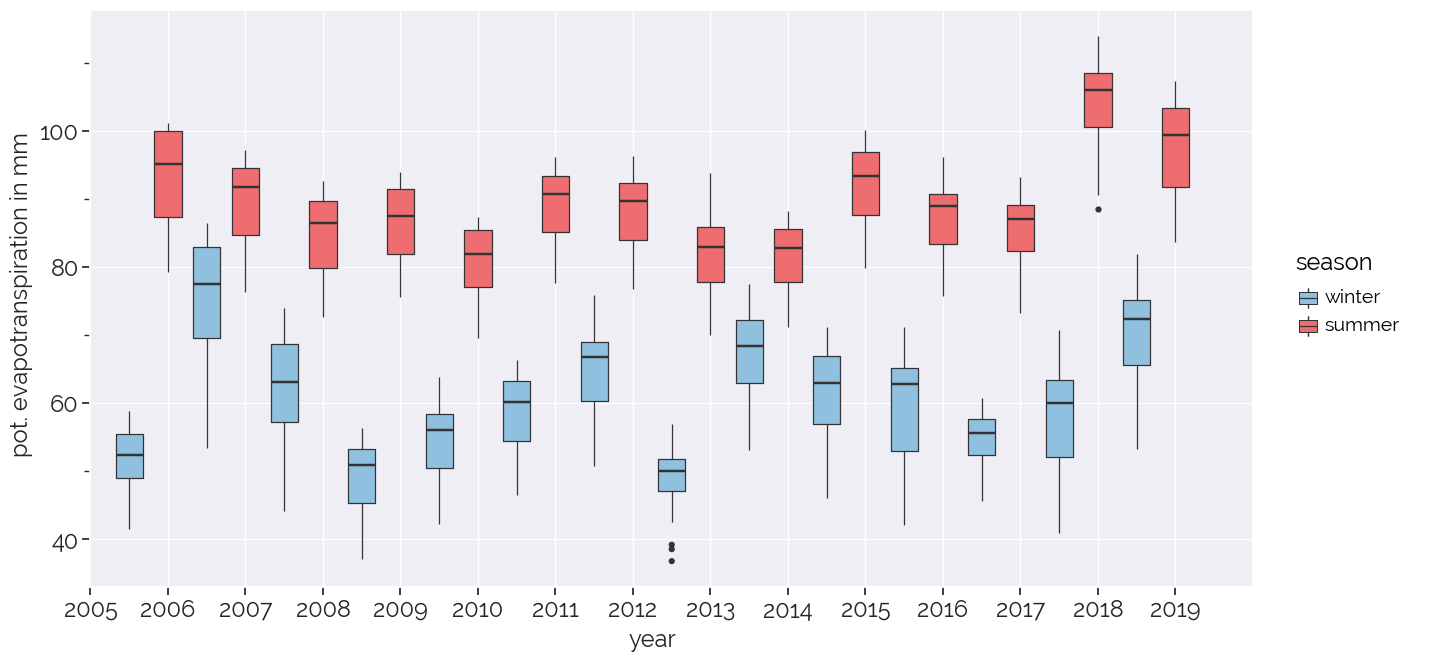

In [27]:
# potential evapotranspiration
climate_boxplot('GRV', 'mean') 

Since the water balance, of which evapotranspiration is a meaningful component, was already examined, it is not surprising that this plot reinforces the established insights. All in all, many chronological boxplots show similar results. 

After reviewing these plots, the separation by summer and winter does seem like a beneficial practise, since the seasons often show dissimilar variable values. To improve the original scatterplots, it would also be of use to look at the climate history, not just at the singular climate value for the respective observation. This way, subsequent dry months would be valued differently than just a single dry month among humid ones. One way of doing this is to look at the rolling mean. Hence, the next iteration of correlation scatter plots for the relationships between target variable and climate parameters will feature the rolling summer values for the features.

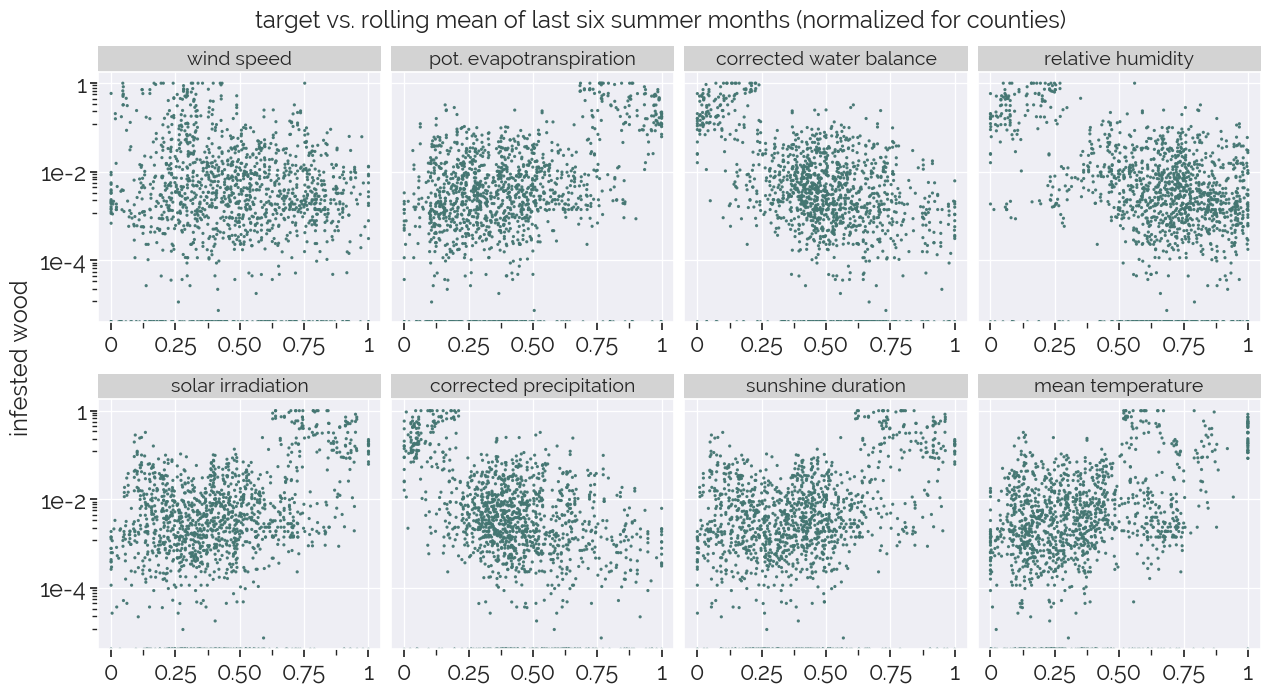

In [28]:
# third graphic - rolling mean of summer months, grouped for counties

# make new labeller function
def mylabeller_rollsr(var):
    label_dict = {
        'FFB_rollsr': 'wind speed',
        'GRV_rollsr': 'pot. evapotranspiration',
        'KWK_rollsr': 'corrected water balance',
        'RF0_rollsr': 'relative humidity',
        'RGK_rollsr': 'solar irradiation',
        'RRK_rollsr': 'corrected precipitation',
        'SD0_rollsr': 'sunshine duration',
        'TM0_rollsr': 'mean temperature',
    }
    return label_dict.get(var)

# use a copied dataframe so transformations aren't applied to main data set
# only take into account years with target variable observations
draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(
    ['county_name', 'timestamp']
)['infested_wood'].transform('sum')


for v in ['TM0_rollsr', 'RF0_rollsr', 'SD0_rollsr', 'RRK_rollsr', 
          'FFB_rollsr', 'RGK_rollsr', 'GRV_rollsr', 'KWK_rollsr']:
    
    # multiply all values by forestry district area (weight)
    draw[v] = draw[v] * draw['area_fdist']
    
    # sum up weighted target variable 
    draw[v] = draw.groupby(['county_name', 'timestamp'])[v].transform('sum')
    
    # sum up all forestry district areas in respective counties
    draw['area_county'] = draw.groupby(['county_name', 'timestamp'])[
        'area_fdist'
    ].transform('sum')
  
    # technically area_county has the area multiplied by 2
    # since there are two observations per forestry district
    # (non-state- and state-owned forest)
    #
    # the same is true for the target variable however so for the 
    # fraction this does not matter
    draw[v] = draw[[v, 'area_county']].apply(lambda x: x[0]/x[1], axis=1)
    
    # normalize target variable with minmax scaler for county
    draw[v] = draw.groupby('county_name')[v].transform(
        lambda x: minmax_scale(x)
    )
    
# drop duplicates    
draw.drop_duplicates(['county_name', 'timestamp'], inplace=True)
draw['infested_wood'] = draw.groupby('county_name')[
    'infested_wood'
].transform(lambda x: minmax_scale(x))

for v in ['TM0_rollsr', 'RF0_rollsr', 'SD0_rollsr', 'RRK_rollsr', 
          'FFB_rollsr', 'RGK_rollsr', 'GRV_rollsr', 'KWK_rollsr']:
    # normalize features with minmax scake for county
    draw[v] = draw.groupby(['county_name'])[v].transform(
        lambda x: minmax_scale(x)
    )
    
# transform from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, id_vars=['infested_wood'],
    value_vars=['TM0_rollsr', 'RF0_rollsr', 'SD0_rollsr', 'RRK_rollsr', 
                'FFB_rollsr', 'RGK_rollsr', 'GRV_rollsr', 'KWK_rollsr']
)

# plot
(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.geom_point(size=.3, alpha=.9, color=mycolors[0])
 + p9.facet_wrap('variable', scales='free_x', 
                 ncol=4, labeller=mylabeller_rollsr)
 + p9.scale_y_log10()
 + p9.ggtitle(
     'target vs. rolling mean of last '
     'six summer months (normalized for counties)'
 )
 + p9.xlab('') + p9.ylab('infested wood')
 + mythemewide
).draw();

This plot at last shows a slight correlation between target variable and climate features. By using the rolling mean for summer values, the observations of the critical years stand out in their own section of the plot. As a result, a weak relationship with the infested wood is apparent. The data shows that a few weeks of warm/dry weather does not immediately result in a higher amount of infested wood. It is the perpetual heat and dryness that contributes to the scope of the infestation. This is in line with the knowledge on spruce and beetle biology, as healthy spruce trees defend themselves against bark beetles by releasing a sap or resin with insecticidal compounds when the beetles try to drill into their bark. Without the necessary water, the trees defense system is weakened, resulting in a mass vulnerability of spruce trees.

In the last of the climate parameter plots, a similar approach is taken. This time, the values are aggregated for each year.

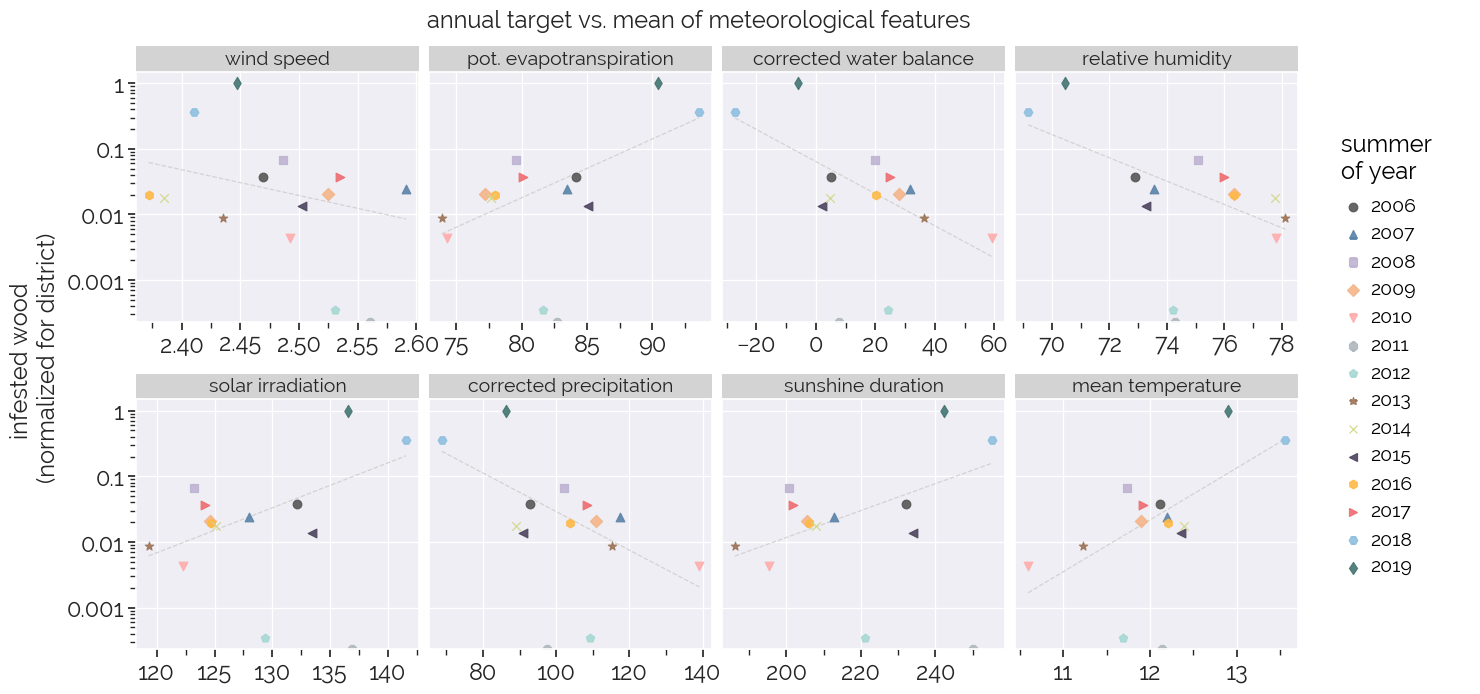

In [29]:
# fourth graphic - only one dot per year (whole year, not just summer)

# use a copied dataframe so transformations aren't applied to main data set
# only take into account years with target variable observations
draw = data[(data['year'].isin(range(2006,2020)))].copy()
draw['infested_wood'] = draw.groupby(['year'])[
    'infested_wood'
].transform('mean')

for v in ['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']:
    draw[v] = draw.groupby(['year'])[v].transform('mean')
    
# drop duplicates    
draw.drop_duplicates(['year'], inplace=True)

# minmax scale
draw['infested_wood'] = draw['infested_wood'].transform(
    lambda x: minmax_scale(x)
)

# transform from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, id_vars=['infested_wood', 'year'], 
    value_vars=['TM0', 'RF0', 'SD0', 'RRK', 'FFB', 'RGK', 'GRV', 'KWK']
)

# plot
(p9.ggplot(
    p9.aes('value', 'infested_wood', 
           color='factor(year)', shape='factor(year)'), 
    data=draw
)
 + p9.geom_smooth(p9.aes(group=1),
     method='lm', se=False, color='lightgrey', size=.5, linetype='--')
 + p9.geom_point(size=3, alpha=.9)
 + p9.facet_wrap('variable', scales='free_x', 
                 ncol=4, labeller=mylabeller_names)
 + p9.ggtitle('annual target vs. mean of meteorological features')
 + p9.xlab('') + p9.ylab('infested wood \n(normalized for district)') 
 + p9.scale_y_log10()
 + p9.scale_color_manual(mycolors[:14][::-1], name='summer \nof year')
 + p9.scale_shape_manual([ 
    'o',  # circle
    '^',  # triangle up
    's',  # square
    'D',  # Diamond
    'v',  # triangle down
    '8',  # octagon
    'p',  # pentagon
    '*',  # star
    'x',  # x
    '<',  # triangle left
    'h',  # hexagon1
    '>',  # triangle right
    'H',  # hexagon1
    'd'   # thin diamond
 ], name='summer \nof year')
 + mythemewide
).draw();

This plot captures the relationships already observed in the last plot. The years 2018 and 2019 are always on the far-left or far-right side of the plot, meaning on one end of the spectrum of the respective features. The notable exception is wind speed. Noticeably the year 2008 (third largest amount of infested wood) does not behave in the same way and is still mostly in the center of the plots and not an outlier regarding these features in any way. It is presumed that the high amount of infested wood in this particular year may not be caused by climate variation, but instead by another feature, such as demolition wood. This would coincide with the expertise of *Sachsenforst*, where windfall & demolition wood is also seen as the reason for the 2008 outbreak.

Since relationships are most apparent in this heavily aggregated, scaled and transformed plot and less apparent in plots with the individual observations, fitting a model on the initial climate features might yield unsatisfactory results.

# 5. Further Parameters
## 5.1 Timeframe 

The timeframe is a categorical feature that denotes the month or quarter that the target variable (**accumulated** infested wood) was observed. Based on the analysis up to this point, the timeframe should have a notable impact on the target since bark beetles go into torpor and the European climate changes notably with the seasons. Seasonality and yearly peaks were also observed in the chronological analysis of the infestation history. The relationship between target variable and timeframe is explored in the following bar plot.

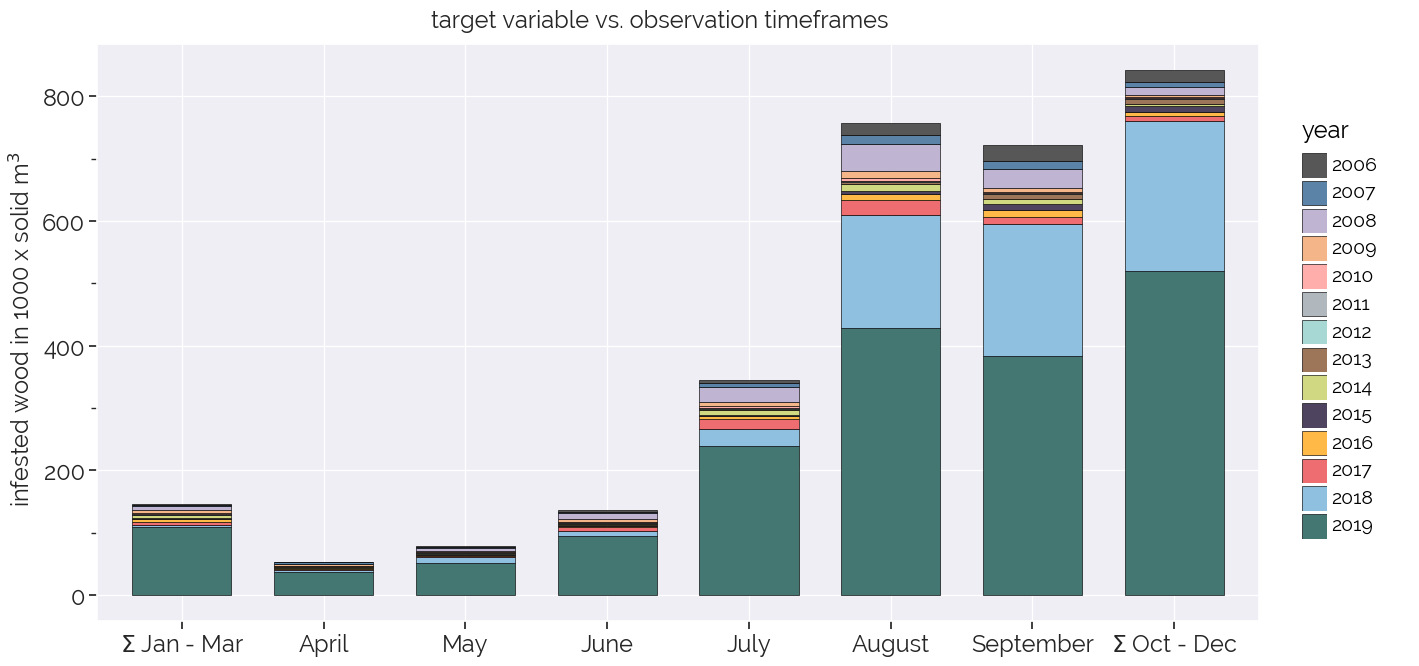

In [30]:
# make a stacked bar plot for infested wood and timeframe
# (infested wood split up by year)

# only include years with complete observations
# (last timeframe of 2020 not yet recorded, would skew the info)
draw = data[(data['year'].isin(range(2006,2020)))].copy()

# group observations by year and timeframe, sum up infested wood
draw = pd.DataFrame(draw.groupby(['year', 'timeframe'])[
    'infested_wood'
].sum() / 1000).reset_index() 

# make plot
(p9.ggplot(p9.aes(
    'timeframe', 'infested_wood', fill='factor(year)'
),data=draw)
 + p9.geom_col(alpha=1, color='black', width=.7, size=.25)
 + p9.scale_x_discrete(labels=[
     r'$\Sigma$ Jan - Mar', 'April', 'May', 'June', 'July', 
     'August', 'September', r'$\Sigma$ Oct - Dec'
 ])
 + p9.scale_fill_manual(mycolors[:14][::-1], name='year')
 + p9.ggtitle('target variable vs. observation timeframes')
 + p9.xlab('') + p9.ylab(r'infested wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

In general, the amount of newly infested wood is lowest in the first six months of a year. The last quarter (October-Dezember) is noteworthy, as it encompasses the highest total amount of infested wood, but only because of the years 2018 and 2019. In most other years the recorded amount was actually lower than in August and September. If we choose the timeframe variable as a feature in the modeling process, this might impact the model in such a way that for the earlier years the yearly maximum is missed and wrongly predicted in the October-December timeframe. It should also be noted that for the January-March as well as October-December timeframes, this plot shows the total (NOT monthly) amount of accumulated wood, so of course the recorded amount for October would still be lower than in September, even for the later years. 

## 5.2 Previous Amount of Infested Wood & Disposing Rate

Based on past investigations, the recent infestation history should have a significant influence on the amount of observed infested wood. There is a variety of features in the data set to choose from that all capture the value of past infested wood observations. A plot that captures the relationship to the target is created for each one. Since multiple of these features might be included in the final model, we will also capture the correlation between them in a heatmap. Contrary to the climate parameters, this time the spearman rank correlation will be used instead of the pearson correlation, as an extremely skewed and distribution of the target variable (which in this case is also a feature) was observed.

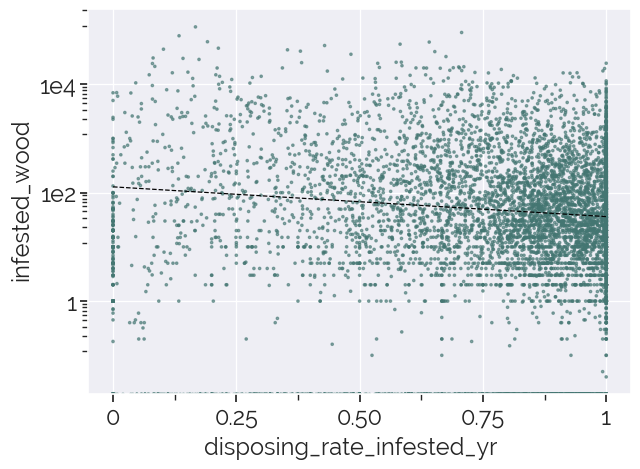

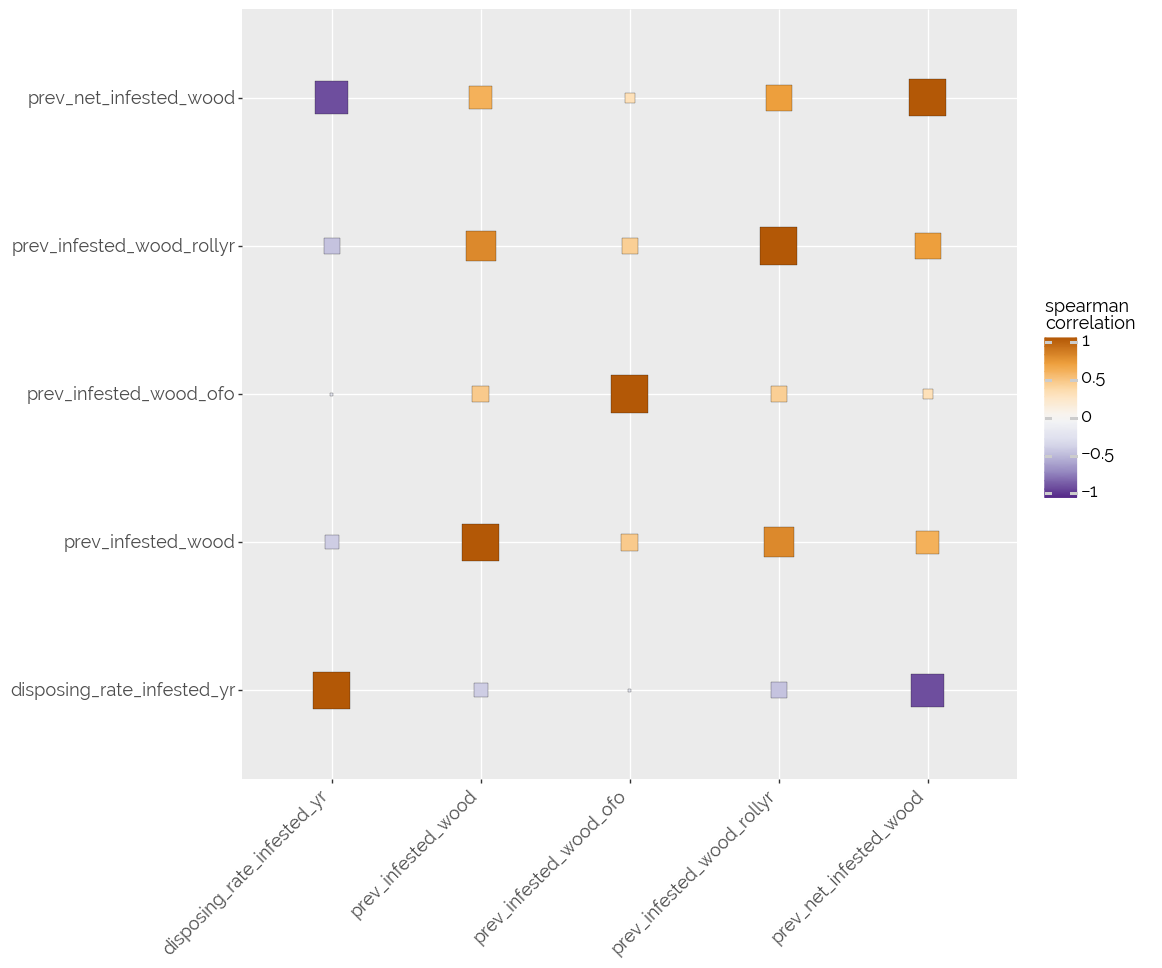

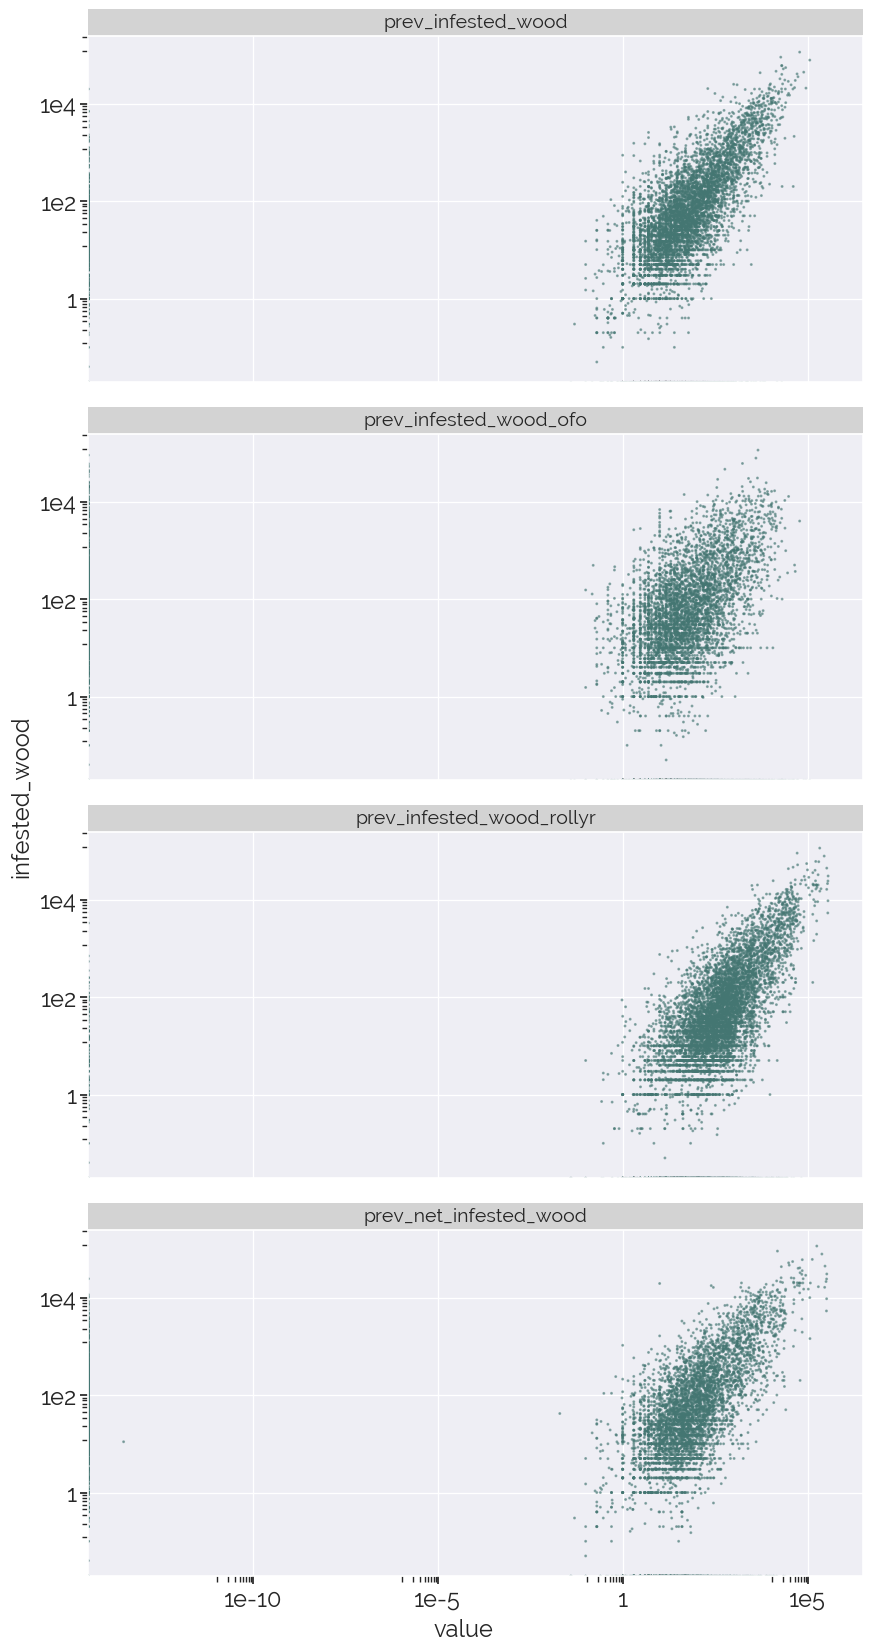

In [31]:
# plot relationship betwenn infested wood and disposing rate
(p9.ggplot(p9.aes('disposing_rate_infested_yr', 'infested_wood'), data=data)
 + p9.geom_point(size=.5, alpha=.6, color=mycolors[0])
 + p9.scale_y_log10()
 + p9.geom_smooth(p9.aes(group=1),
     method='lm', se=False, color='black', size=.5, linetype='--')
 + mytheme
 + p9.theme(figure_size = (7,5))
).draw();

# plot relationship between infested wood and features for past infestation
# get relevant features
draw = data[[
    'infested_wood', 
    'prev_infested_wood', 
    'prev_infested_wood_ofo', 
    'prev_infested_wood_rollyr', 
    'disposing_rate_infested_yr'
]]

# construct net infested wood out of 
# disposing_rate_infested_yr and prev_infested_wood_rollyr
draw['prev_net_infested_wood'] = (
    1 - draw['disposing_rate_infested_yr']
) * draw['prev_infested_wood_rollyr']

# select columns for correlation heatmap
columns = [    
    'prev_infested_wood', 
    'prev_infested_wood_ofo', 
    'prev_infested_wood_rollyr', 
    'disposing_rate_infested_yr',
    'prev_net_infested_wood'
]

# calculate spearman correlation
corr = draw[columns].corr(method='spearman')

# Unpivot the dataframe, so we can get pair of arrays for x and y 
# (long format)
corr = pd.melt(corr.reset_index(), id_vars='index') 
corr.columns = ['x', 'y', 'value']

# plot heatmap
heatmap( 
    x=corr['x'], 
    y=corr['y'], 
    size=corr['value'].abs(), 
    color = corr['value'],
    pear=False
)

# transform draw from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, id_vars=['infested_wood'], 
    value_vars=[
        'prev_infested_wood', 
        'prev_infested_wood_ofo', 
        'prev_infested_wood_rollyr', 
        'prev_net_infested_wood']
)

# make plot
(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.facet_wrap('variable', ncol=1)
 + p9.geom_point(size=.2, alpha=.5, color=mycolors[0])
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + mytheme
 + p9.theme(figure_size = (10, 20),
           subplots_adjust={'hspace': 0.15})
).draw();

The disposing rate itself does not show a strong relationship with the target variable, although a slight decline of the target variable is ascertainable with a rising disposing rate. In contrast, all variations of the previous wood variable show a stronger and similar relationship with the target (if plotted on two log10 axes). The heatmap can aid in choosing a suitable subset of these variables for model training. For example the previous observation of infested wood in the other respective forest ownership can "safely" be used in combination with the other features, as it is an explanatory variable that does influence the target but does not correlate with the other features. The "net" infested wood on the other hand, which we created with the previous infested wood and the disposing rate, does not offer new, independent information and thus will be excluded in the model training process.

## 5.3 Demolition Wood & Demolition Wood Disposing Rate

According to Sachsenforst, the windfall and demolition wood is a prime candidate for inclusion as a feature in the prediction model and together with the climate parameters should describe the infestation rather well. The high infestation in the year 2008 is attributed to severe weather conditions leading to an abundance of dead wood for beetles to breed in. Let's show the general demolition wood development over the years.

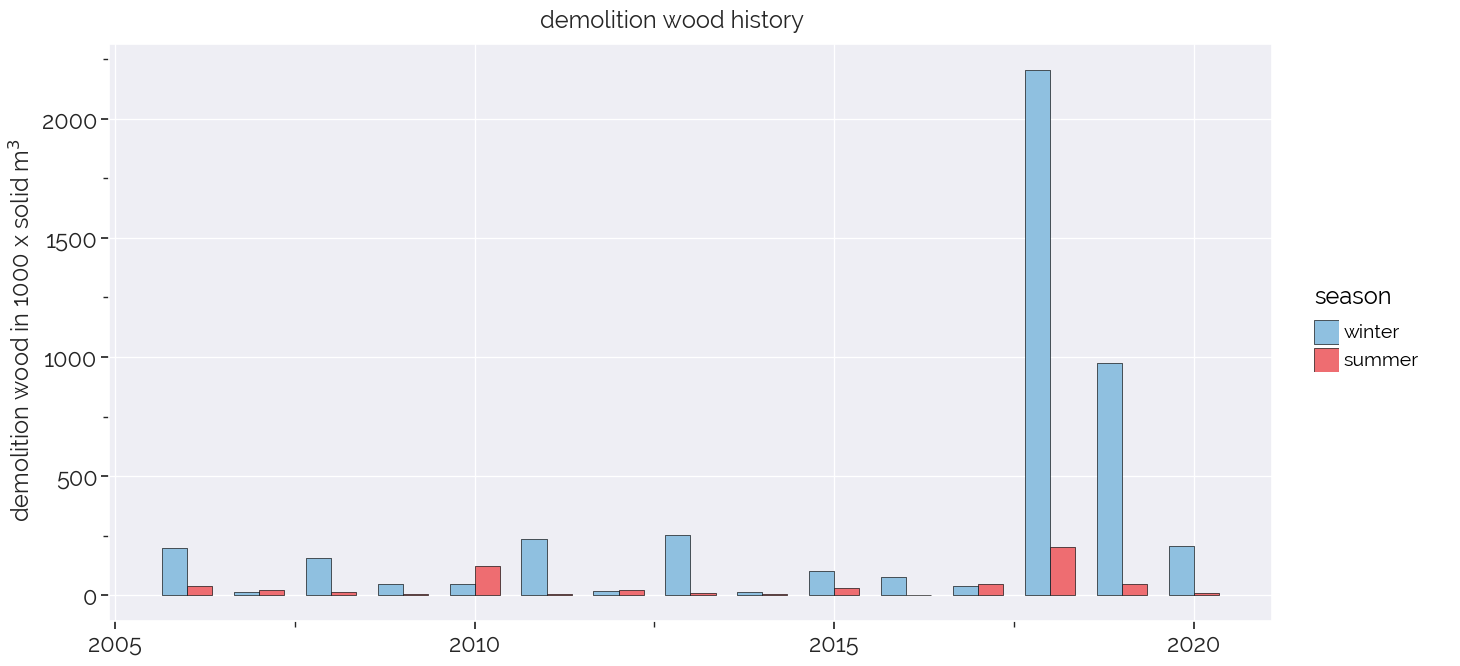

In [32]:
# plot the demolition wood history

# only include years from 2006 onward
draw = data[data['year']>=2006].copy()
             
# demolition wood is reported semi-annually
# In April the winter figures get reported and in September the summer figures
# only need the two respective observations each year
draw = draw[draw['timestamp'].map(lambda x: x.month).isin([4,9])]             


# group observations by year and timeframe, sum up demolition wood
draw = pd.DataFrame(draw.groupby(['year', 'timeframe'])[
    'demolition_wood'
].sum() / 1000).reset_index() 

# make plot
(p9.ggplot(p9.aes(
    'year', 'demolition_wood', fill='factor(timeframe)'
),data=draw)
 + p9.geom_col(alpha=1, color='black', width=.7, 
               size=.25, position='dodge')
 + p9.scale_fill_manual(mycolors[1:3], name='season', 
                        labels=['winter', 'summer'])
 + p9.ggtitle('demolition wood history')
 + p9.xlab('') + p9.ylab(r'demolition wood in 1000 x solid m$^3$')
 + mythemewide
).draw();

In general the demolition wood reported in winter is roughly on par or exceeds the amount of demolition wood reported in summer. One reason is that in winter snow and ice damages occur on top of the other abiotic damage sources (such as storm damages) and some trees might die in winter as a result of the harsh drought conditions in summer (or just get recorded in these months). This explanation is supported by the figures of the years with dry and hot summers (2018-2020), as the winter demolition wood is still far higher in these years. Another reason is that 'winter' in the context of demolition wood encompasses two more months than summer according to the reporting schedule. For example the winter 2010 is reported in April 2010 and encompasses accumulated demolition wood from October 2009 until April 2010 (7 months) in contrast to the summer 2010 which is reported in September 2010 (5 months). 

In the year 2008 a moderate amount of demolition wood was accumulated. However the year is not a heavy outlier among the years 2006 - 2017. So the explanation from *Sachsenforst* regarding the notable infestation in this year is not supported by the data. Then again the data only shows the total amount of demolition wood and not the different abiotic damage sources, so *Sachsenforst* may have some background knowledge or further expertise that is not available to our prediction model, which only is trained on the data we have. 

The time has come to explore the relationship between infested and demolition wood:

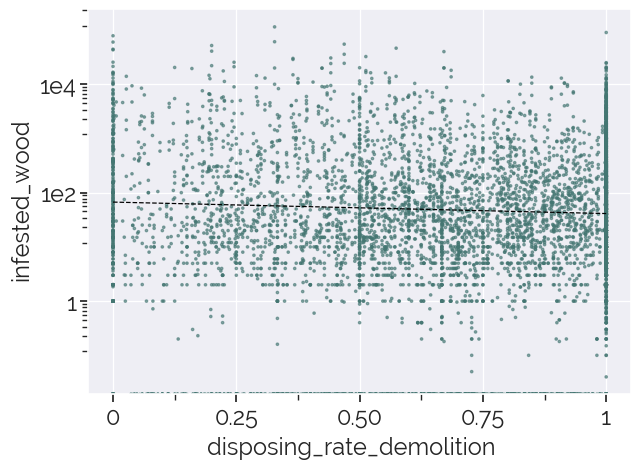

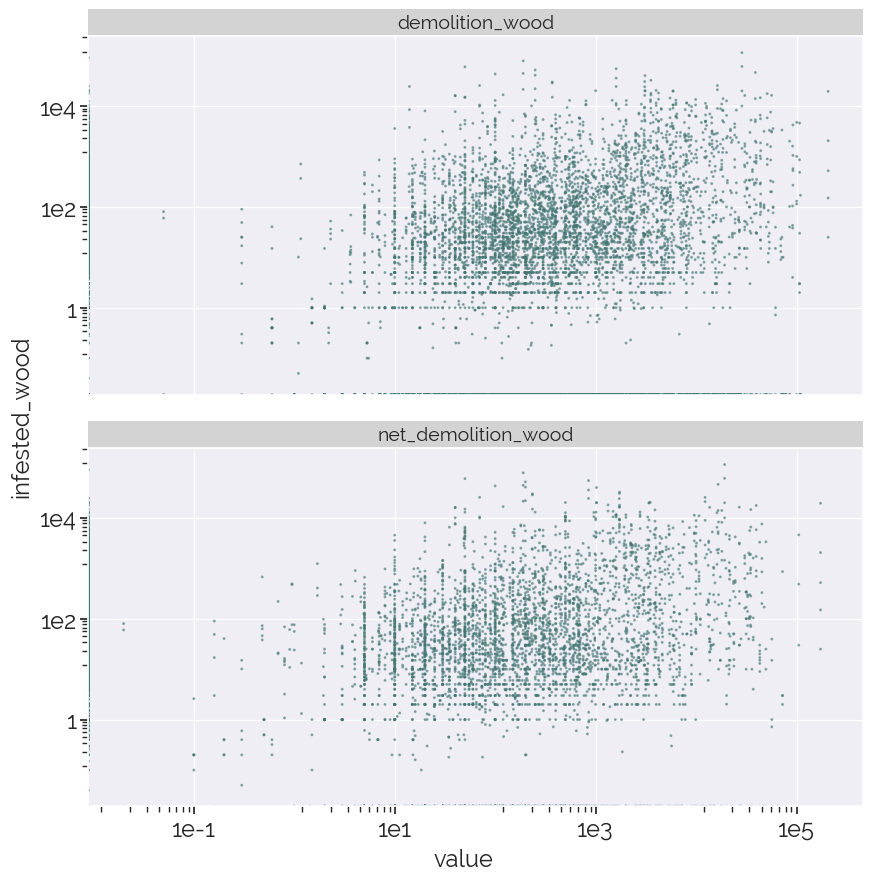

In [33]:
# plot relationship between demolition wood and demolition disposing rate
(p9.ggplot(p9.aes('disposing_rate_demolition', 'infested_wood'), data=data)
 + p9.geom_point(size=.5, alpha=.6, color=mycolors[0])
 + p9.scale_y_log10()
 + p9.geom_smooth(p9.aes(group=1),
     method='lm', se=False, color='black', size=.5, linetype='--')
 + mytheme
 + p9.theme(figure_size = (7,5))
).draw();


# plot relationship between infested wood and demolition wood

# get relevant features
draw = data[[
    'infested_wood', 
    'demolition_wood', 
    'disposing_rate_demolition' 
]]

# construct net demolition wood out of 
# disposing_rate_demolition and demolition_wood
draw['net_demolition_wood'] = (
    1 - draw['disposing_rate_demolition']
) * draw['demolition_wood']

# transform from wide to long format as plotnine likes tidy data
draw = pd.melt(
    draw, id_vars=['infested_wood'], 
    value_vars=[
        'net_demolition_wood', 
        'demolition_wood'
    ]
)

# make plot
(p9.ggplot(p9.aes('value', 'infested_wood'), data=draw)
 + p9.facet_wrap('variable', ncol=1)
 + p9.geom_point(size=.2, alpha=.5, color=mycolors[0])
 + p9.scale_y_log10()
 + p9.scale_x_log10()
 + mytheme
 + p9.theme(figure_size = (10, 10),
           subplots_adjust={'hspace': 0.15})
).draw();

Again the disposing rate shows a weak negative correlation the the target variable. The relationship between demolition wood (as well as net demolition wood) seems to be weaker than indicated by *Sachsenforst*. The logical connection that demolition wood is a breeding gound for bark beetles and disposing it is a main factor in fighting the infestation only partially supported by the data.